# Predict Clicked Ads Customer Classification by using Machine Learning

A company in Indonesia wishes to assess the effectiveness of an advertisement they have broadcasted. This is crucial for the company to gauge the reach of their marketing campaign and attract customers to view the advertisement. By analyzing historical advertisement data and uncovering insights and patterns, this can aid the company in establishing marketing targets. <b>The primary focus of this case is to develop a machine learning classification model that can identify the right target customers</b>.

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, cross_val_score, cross_validate, RandomizedSearchCV, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
kf = KFold(10, shuffle=True, random_state=0)

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from scipy.stats import uniform

import re
import shap

import warnings
warnings.filterwarnings("ignore") # Ignores any warning

pd.set_option('float_format', '{:.2f}'.format) # Scientific format with 2 numbers
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set(rc={'figure.figsize':(15, 8)})
sns.set_style("whitegrid")

In [ ]:
df = pd.read_csv('Clicked Ads Dataset.csv')

In [ ]:
df.sample(3)

Unnamed: 0  Daily Time Spent on Site  Age  Area Income  \
162         162                     72.01   31 404298230.00   
387         387                     44.46   42 213412360.00   
8             8                     74.53   30 482034000.00   

     Daily Internet Usage       Male        Timestamp Clicked on Ad  \
162                251.00  Perempuan  2/29/2016 12:31            No   
387                132.66  Laki-Laki  1/15/2016 19:40           Yes   
8                  221.51  Laki-Laki   4/18/2016 9:33            No   

               city        province category  
162  Bandar Lampung         Lampung  Fashion  
387        Surabaya      Jawa Timur  Fashion  
8             Batam  Kepulauan Riau     Bank

#### Data Dictionary:
1. Daily Time Spent on Site: Average amount of time (in minutes) spent by customers on the website per day
2. Age: Age of customers who clicked on the ad
3. Area Income: Average income of the area where customers are located
4. Daily Internet Usage: Average amount of time (in minutes) customers spend on the internet per day
5. Male: Gender of customers
6. Timestamp: Time when customers clicked on the ad
7. Clicked on Ad: Target variable, indicating whether customers clicked on the ad (Yes) or not (No)
8. city: Name of the city where customers are located
9. province: Name of the province where customers are located
10. category: Category of the ad clicked by customers

## Exploratory Data Analysis (EDA)

In [ ]:
# Drop unnecessary column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# Check data types and detect the presence of null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  987 non-null    float64
 1   Age                       1000 non-null   int64  
 2   Area Income               987 non-null    float64
 3   Daily Internet Usage      989 non-null    float64
 4   Male                      997 non-null    object 
 5   Timestamp                 1000 non-null   object 
 6   Clicked on Ad             1000 non-null   object 
 7   city                      1000 non-null   object 
 8   province                  1000 non-null   object 
 9   category                  1000 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 78.2+ KB


In [ ]:
# Check total null values
df.isna().sum()

Daily Time Spent on Site    13
Age                          0
Area Income                 13
Daily Internet Usage        11
Male                         3
Timestamp                    0
Clicked on Ad                0
city                         0
province                     0
category                     0
dtype: int64

**Summary:**
- The dataset consists of 1000 rows and 10 columns.
- There are missing values in the `Daily Time Spent on Site` column (13 data points), `Area Income` column (13 data points), `Daily Internet Usage` column (11 data points), and `Male` column (3 data points).
- The data type in the Timestamp column has been changed to date time.
- It might be better to standardize the column names and their content to use a single language.

In [ ]:
# Check duplicated data
df.duplicated().sum()

0

**Summary:**
- Dataset contains no duplicates

### Statistical Analysis

In [ ]:
# Separate categorical and numerical columns

num_cols = []
cat_cols = []

for a, i in df.items():
    if a != 'Timestamp': # To exclude the 'Timestamp' column because it is neither categorical nor numerical in type
        if i.dtype == 'object':
            cat_cols.append(a)
        else:
            num_cols.append(a)

print(f'Categorical columns: {cat_cols}')
print(f'Numerical columns: {num_cols}')

Categorical columns: ['Male', 'Clicked on Ad', 'city', 'province', 'category']
Numerical columns: ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']


#### Categorical Summaries

In [ ]:
df[cat_cols].describe().T

count unique                            top freq
Male            997      2                      Perempuan  518
Clicked on Ad  1000      2                             No  500
city           1000     30                       Surabaya   64
province       1000     16  Daerah Khusus Ibukota Jakarta  253
category       1000     10                       Otomotif  112

In [ ]:
for col in cat_cols:
    print(f'Value counts {col} columns:')
    print(df[col].value_counts(), end='\n\n')

Value counts Male columns:
Perempuan    518
Laki-Laki    479
Name: Male, dtype: int64

Value counts Clicked on Ad columns:
No     500
Yes    500
Name: Clicked on Ad, dtype: int64

Value counts city columns:
Surabaya             64
Bandung              64
Jakarta Timur        63
Jakarta Selatan      61
Jakarta Barat        57
Bekasi               56
Medan                48
Jakarta Utara        45
Palembang            42
Semarang             41
Batam                34
Makassar             33
Tangerang Selatan    33
Tangerang            32
Depok                30
Bandar Lampung       29
Bogor                28
Jakarta Pusat        27
Malang               26
Banjarmasin          23
Pakanbaru            23
Denpasar             21
Padang               19
Balikpapan           18
Cimahi               17
Samarinda            16
Tasikmalaya          15
Pontianak            12
Surakarta            12
Serang               11
Name: city, dtype: int64

Value counts province columns:
Daerah Khusus Ib

**Summary:**
- `518` customers are female, while `479` others are male.
- <b>Both the total number of customers who clicked on the ad and the total number of customers who did not click on the ad are 500 customers.</b>
- Customers are distributed across 30 cities, with the cities of `Surabaya` and `Bandung` having the highest total number of customers.
- Customers are distributed across 16 provinces, with the province of `DKI Jakarta` having the highest total number of customers.
- There are 10 ad categories, with `Otomotif` being the most frequent.

#### Numerical Summaries

In [ ]:
df[num_cols].describe().T

count         mean         std         min  \
Daily Time Spent on Site  987.00        64.93       15.84       32.60   
Age                      1000.00        36.01        8.79       19.00   
Area Income               987.00 384864670.64 94079989.57 97975500.00   
Daily Internet Usage      989.00       179.86       43.87      104.78   

                                  25%          50%          75%          max  
Daily Time Spent on Site        51.27        68.11        78.46        91.43  
Age                             29.00        35.00        42.00        61.00  
Area Income              328632990.00 399068320.00 458355450.00 556393600.00  
Daily Internet Usage           138.71       182.65       218.79       267.01

**Summary:**
- Customers' daily time spent on the site varies from `32.60 to 91.43 minutes`, with an average customer spending approximately `68.11 minutes (1 hour)`.
- Customers' age varies from `19 to 61 years old`, with an average customer age of `35 years`.
- Area income of customers varies from `97,975,500 to 556,393,600 IDR`, with an average area income customers of `458,355,450 IDR`.
- Customers' daily internet usage varies from `104.78 to 267.01 minutes`, with an average customer usage of approximately `182.65 minutes (3 hours)`.

### Univariate Analysis

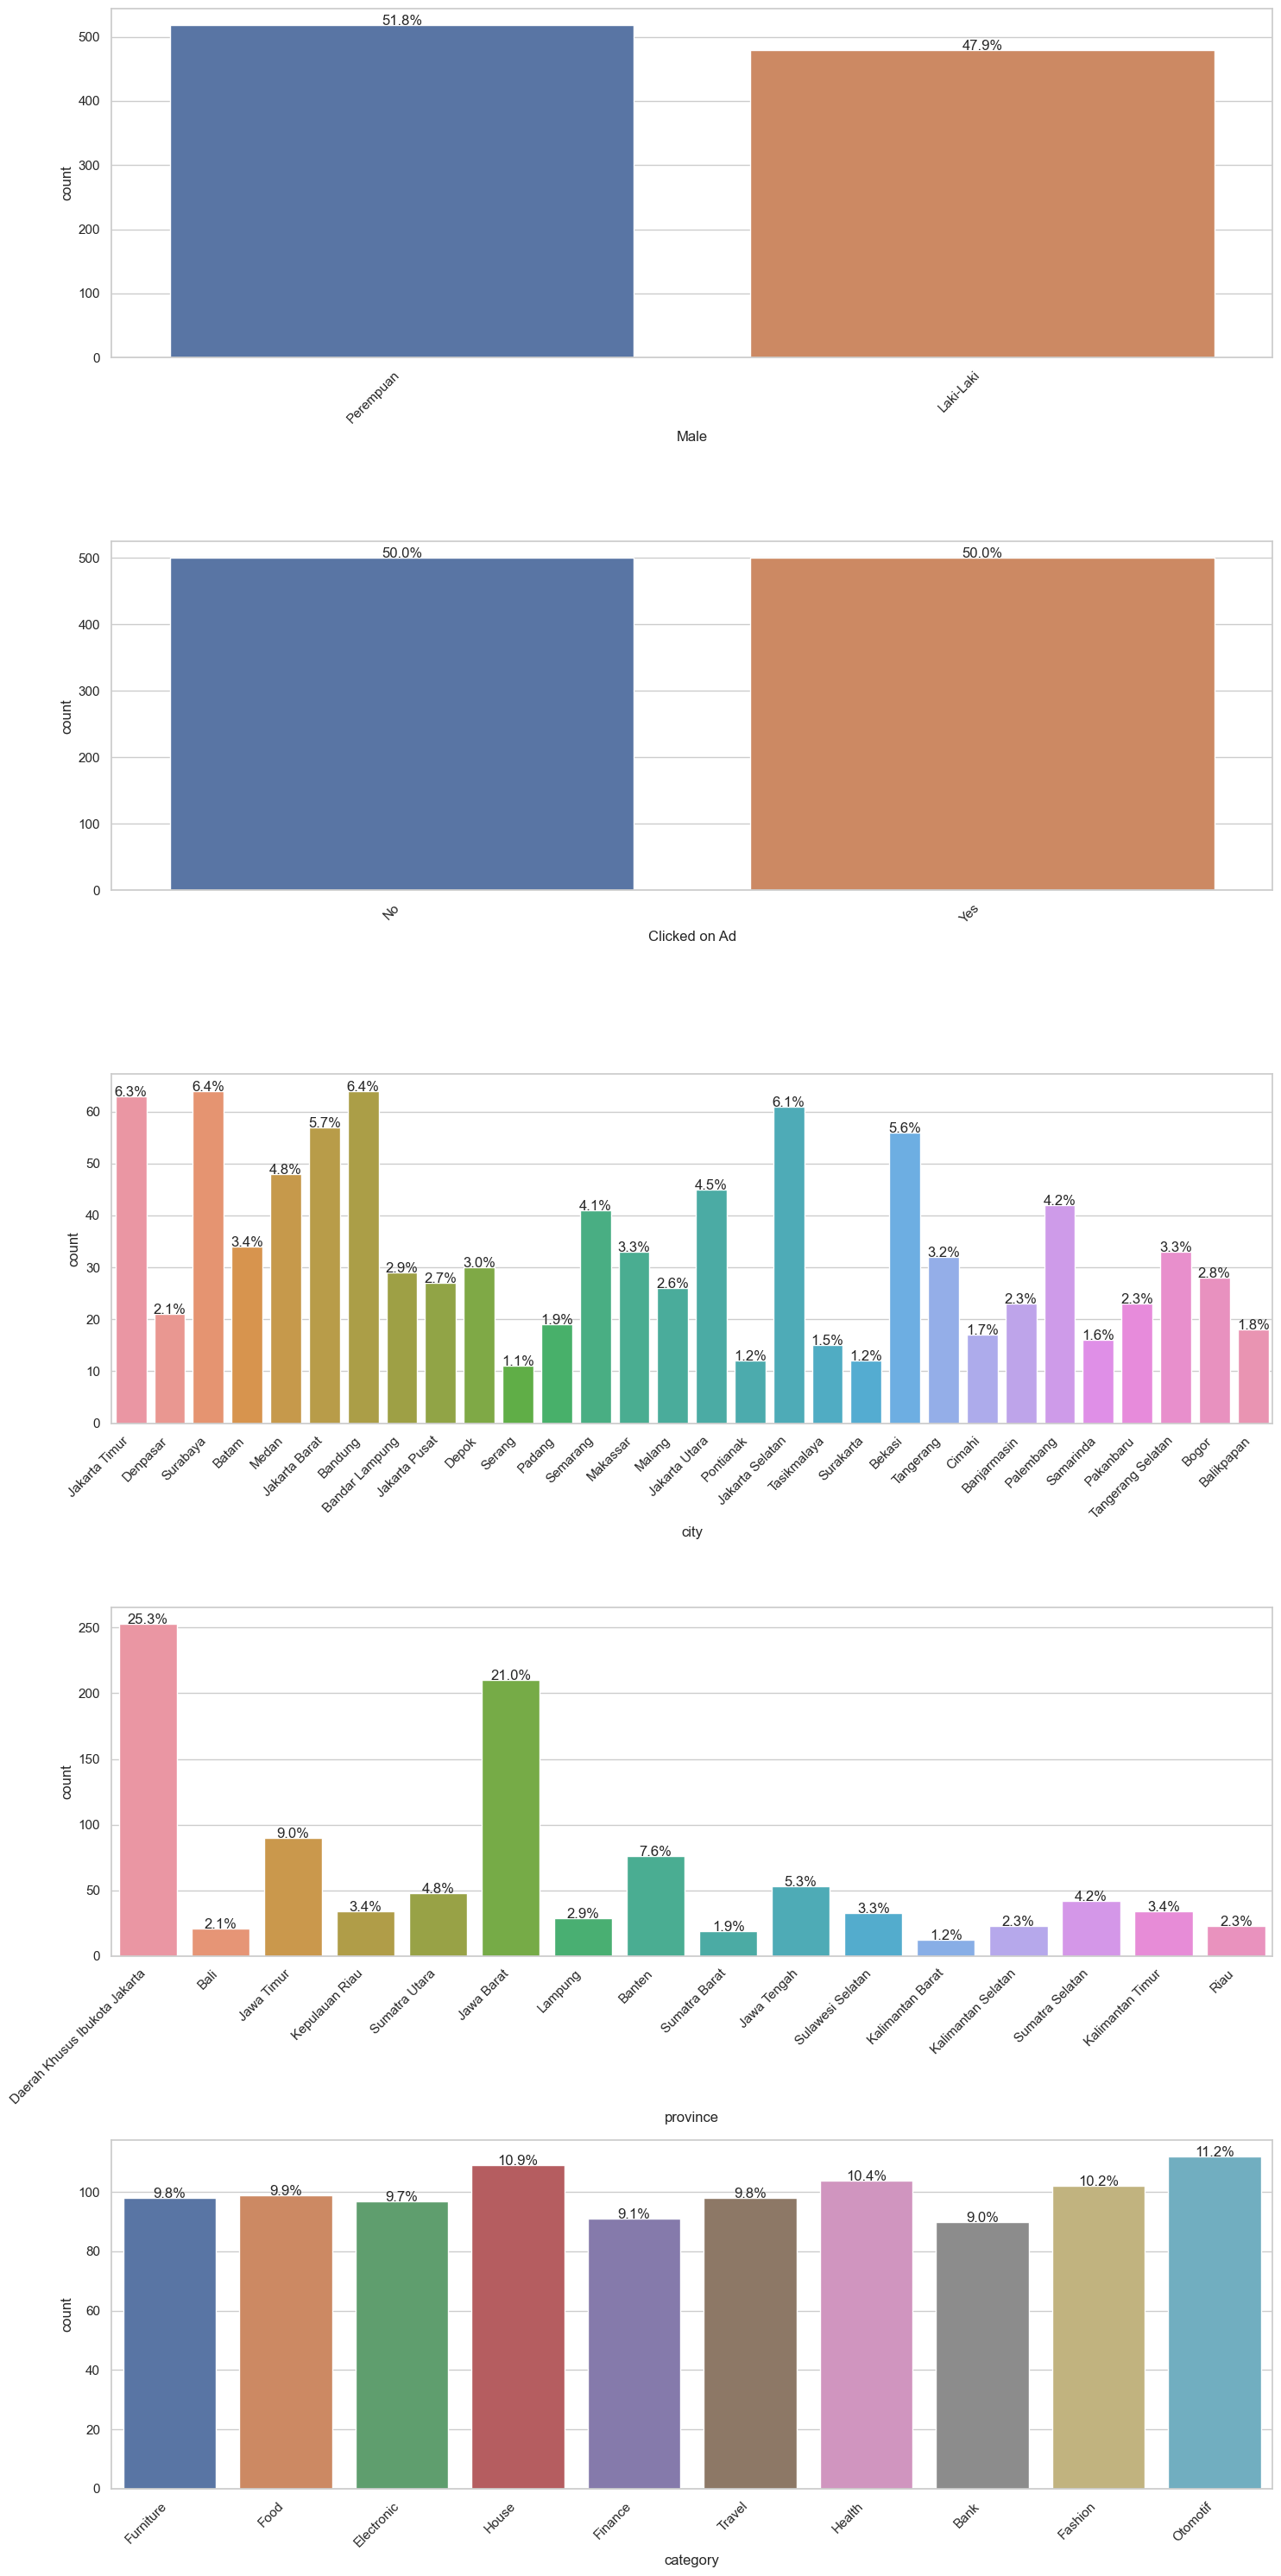

In [ ]:
plt.figure(figsize=(15, 30))
for i in range(0, len(cat_cols)):
    plt.subplot(len(cat_cols)//1, 1, i+1)
    ax = sns.countplot(x=df[cat_cols[i]])

    total = len(df[cat_cols[i]])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + (p.get_width() / 2) #- 0.05
        y = p.get_height()
        ax.annotate(percentage, (x, y), fontsize=12,ha='center')

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

plt.show()

**Summary:**
- More customers are female (51.8%) compared to male customers (47.9%).
- <b>Both the total number of users who clicked on the ad and the total number of users who did not click on the ad are equal, at 50%.</b>
- The cities of `Surabaya` and `Bandung` (6.4%) have the highest total number of customers, while the city of `Serang` (1.1%) has the fewest total number of customers.
- The province of `DKI Jakarta` has the highest total number of customers (25.3%), while the province of `Kalimantan Barat` has the fewest total number of customers (1.2%).
- The `Otomotif` ad category is the most frequent (11.2%), while the `Bank` ad category is the least frequent (9.0%).

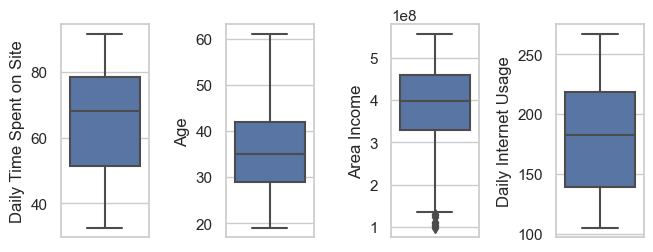

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(0, len(num_cols)):
    plt.subplot(2, 6, i+1)
    sns.boxplot(y=df[num_cols[i]], orient='v')
    plt.tight_layout()

In [ ]:
outlier_data = []

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    # Identification of Outliers
    filter_outlier = (df[col] < low_limit) | (df[col] > high_limit)
    num_outliers = filter_outlier.sum()
    num_no_outliers = len(df) - num_outliers

    outlier_data.append({
        "Column Name": col,
        "is Outlier": num_outliers > 0,
        "Outlier": num_outliers,
        "No Outlier": num_no_outliers
    })

outlier_df = pd.DataFrame(outlier_data)
outlier_df

Column Name  is Outlier  Outlier  No Outlier
0  Daily Time Spent on Site       False        0        1000
1                       Age       False        0        1000
2               Area Income        True        8         992
3      Daily Internet Usage       False        0        1000

**Insight:**
- Outliers are present in the `Area Income` column.

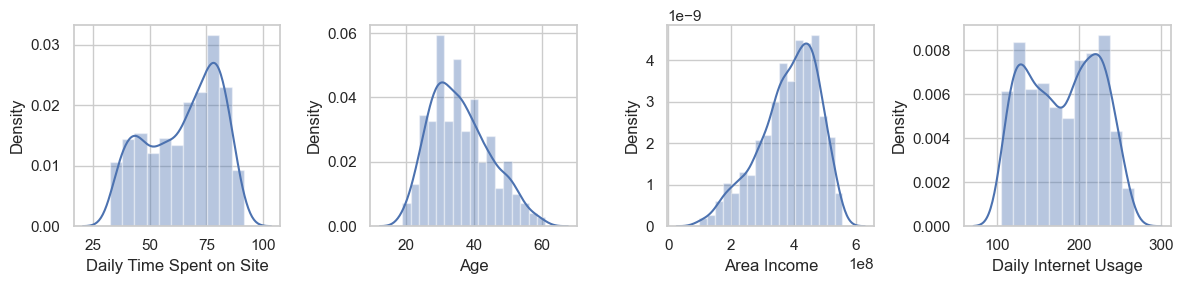

In [ ]:
plt.figure(figsize=(12, 3))
for i in range(0, len(num_cols)):
    plt.subplot(1, 4, i+1)
    sns.distplot(df[num_cols[i]])
    plt.tight_layout()

**Summary:**
- `Age`: Positively Skewed
- `Daily Time Spent on Site`, `Area Income`: Negatively Skewed
- `Daily Internet Usage`: Bimodal Distribution

### Bivariate Analysis

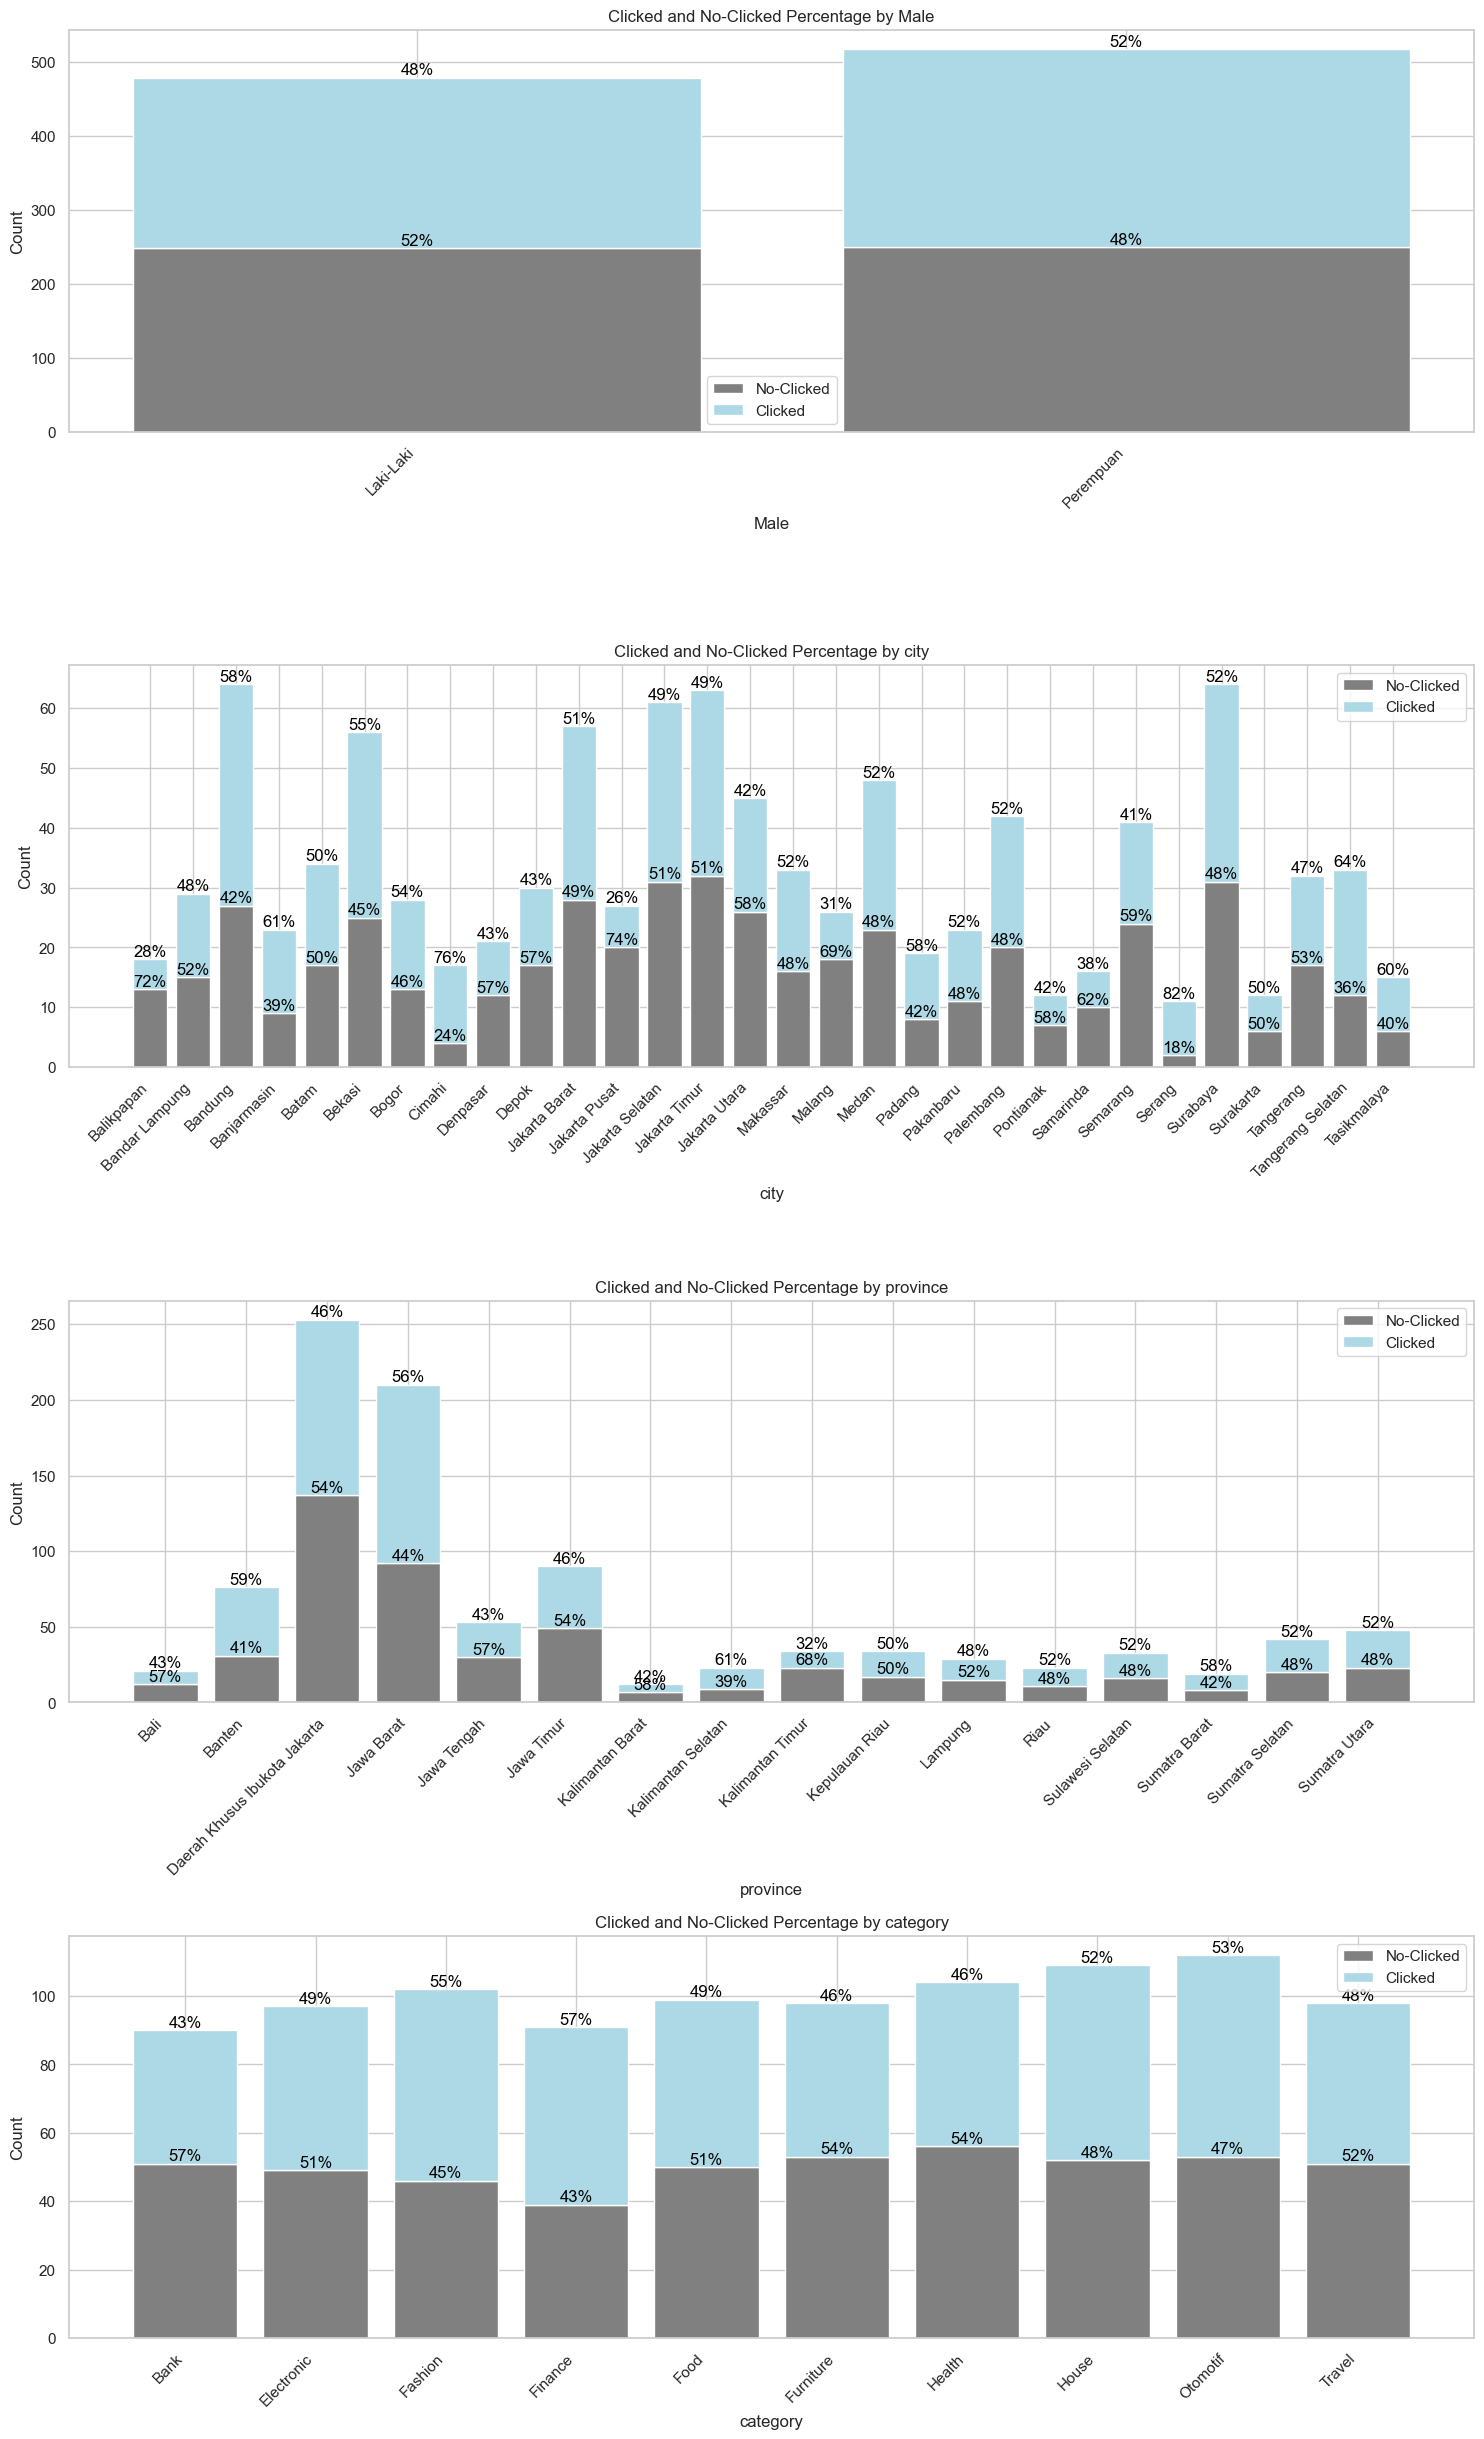

In [ ]:
"""
Analysis of categorical columns involves examining the relationship between individual categorical
features and the target variable. (Bivariate Analysis)
"""
cats = ['Male', 'city', 'province', 'category']

plt.figure(figsize=(15, 30))
for i in range(0, len(cats)):
    plt.subplot(5, 1, i + 1)

    count_by_cat = df[cats[i]].value_counts()

    clicked_data = df.groupby([cats[i], 'Clicked on Ad']).size().unstack().fillna(0)

    clicked_data['no_clicked_percentage'] = (clicked_data['No'] / (clicked_data['No'] + clicked_data['Yes'])) * 100
    clicked_data['clicked_percentage'] = (clicked_data['Yes'] / (clicked_data['No'] + clicked_data['Yes'])) * 100

    plt.bar(clicked_data.index, clicked_data['No'], color='grey', label='No-Clicked')
    plt.bar(clicked_data.index, clicked_data['Yes'], bottom=clicked_data['No'], color='lightblue', label='Clicked')

    for j, (clicked_percentage, no_clicked_percentage) in enumerate(zip(clicked_data['clicked_percentage'], clicked_data['no_clicked_percentage'])):
        plt.text(j, clicked_data['Yes'][j] + clicked_data['No'][j], f'{clicked_percentage:.0f}%', ha='center', va='bottom', color='black')
        plt.text(j, clicked_data['No'][j], f'{no_clicked_percentage:.0f}%', ha='center', va='bottom', color='black')

    plt.xticks(range(len(clicked_data.index)), clicked_data.index, rotation=45, ha="right")
    plt.xlabel(cats[i])
    plt.ylabel('Count')
    plt.title(f'Clicked and No-Clicked Percentage by {cats[i]}')
    plt.legend()

plt.tight_layout()
plt.show()

**Summary:**
- There is 48% of the total female users and 52% of the total male users  did not click on the ad.
- The city with the highest customers who clicked is `Serang` (82%), while the city with the fewest number of clicks is `Jakarta Pusat` (26%).
- The province with the highest customers who clicked is `Kalimantan Selatan` (61%), while the province with the fewest number of clicks is `Kalimantan Timur` (32%).
- The category with the highest number of clicks is `Finance` (57%), while the category with the fewest clicks is `Bank` (43%).

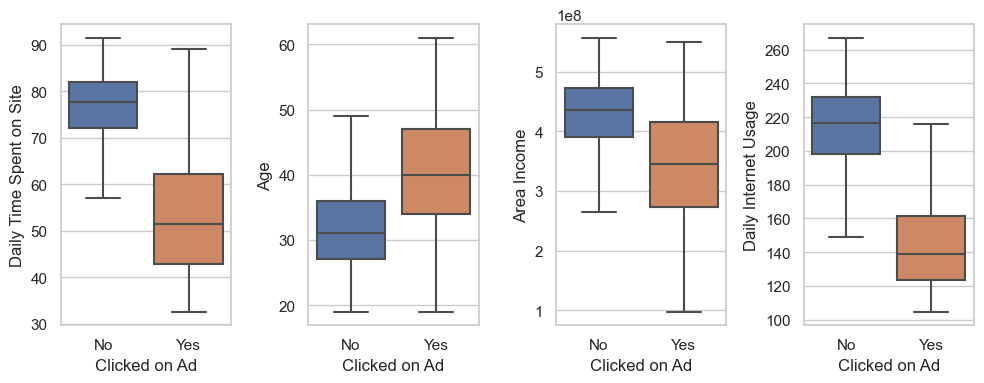

In [ ]:
"""
Analysis of numerical columns involves examining the relationship between individual categorical
features and the target variable. (Bivariate Analysis)
"""

plt.figure(figsize=(10, 4))
for i in range(0, len(num_cols)):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y = df[num_cols[i]], x = df['Clicked on Ad'], orient='v', showfliers = False)
    plt.tight_layout()

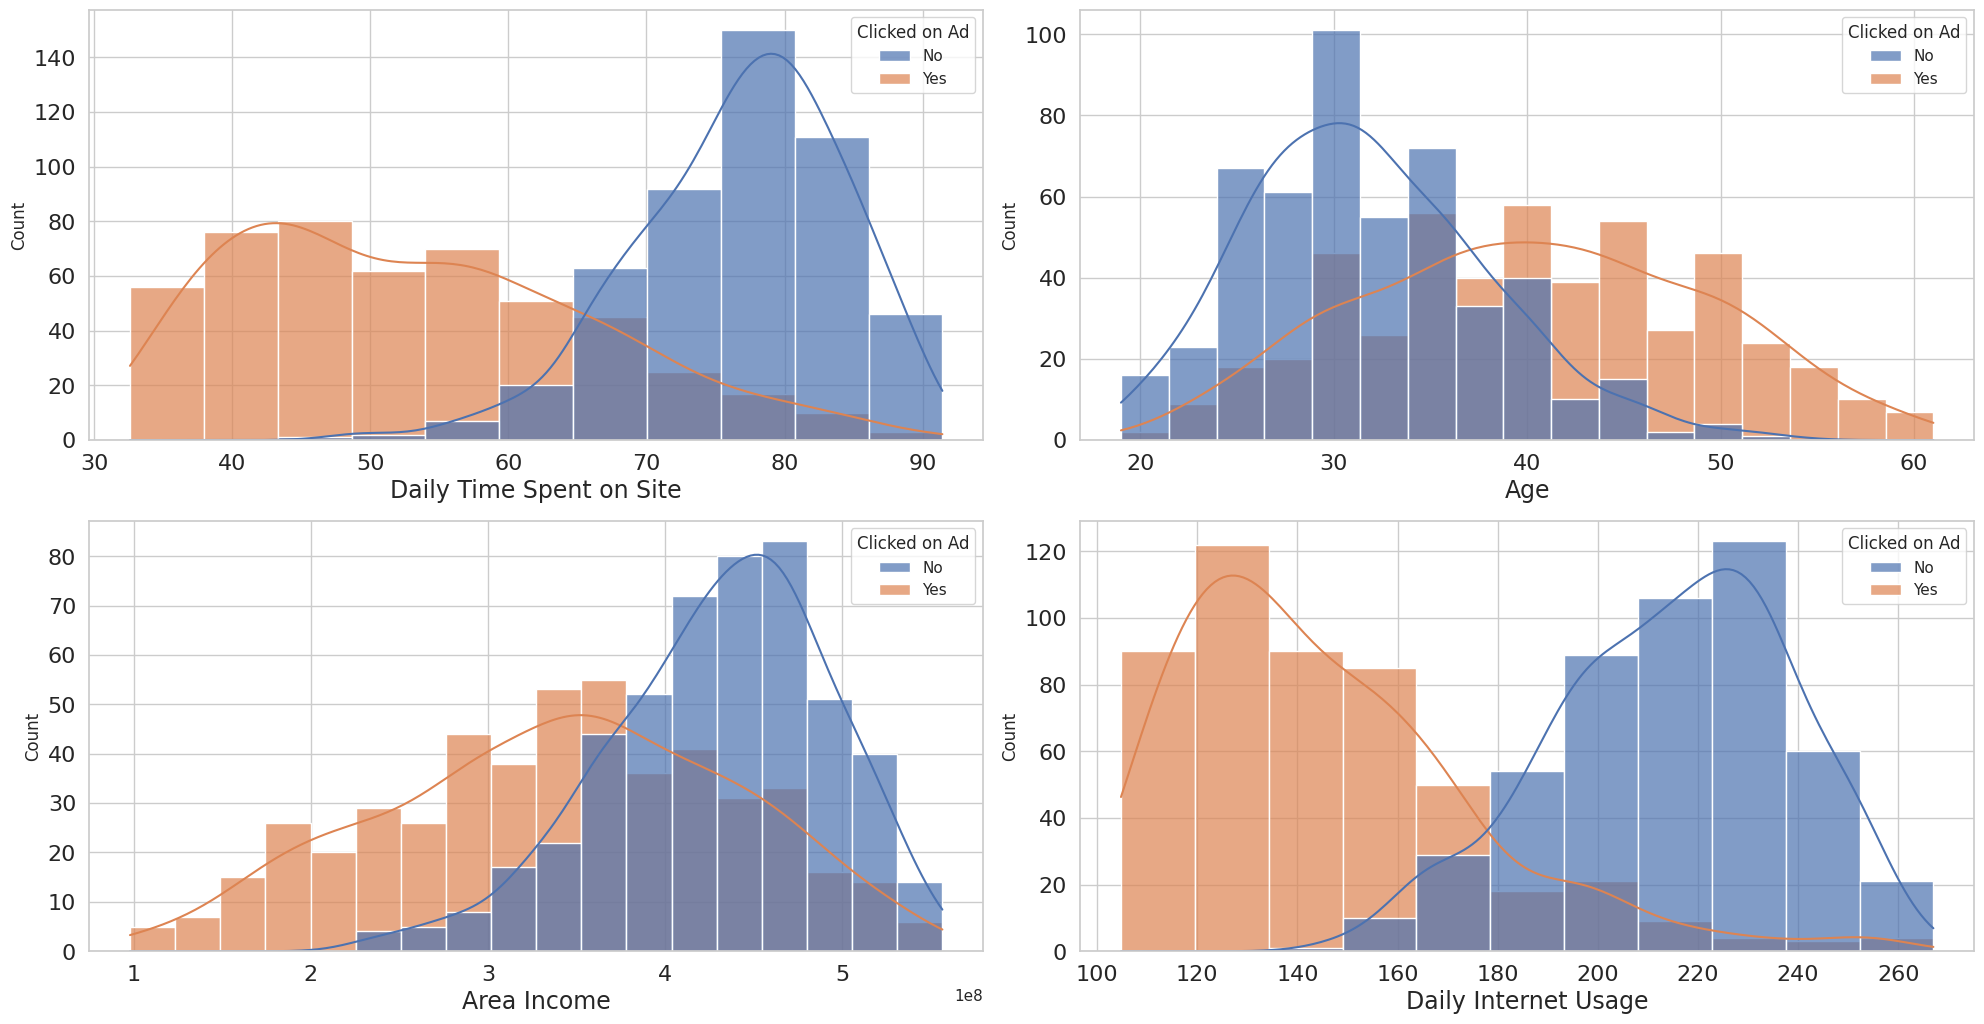

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(0, len(num_cols)):
    plt.subplot(len(num_cols)//1, 2, i+1)
    ax = sns.histplot(x = df[num_cols[i]], kde = True, hue = df['Clicked on Ad'], alpha = 0.7)
    ax.set_xlabel(str(num_cols[i]), fontsize = 17)
    ax.tick_params(labelsize=16)

    # plt.title(f'Clicked and No-Clicked by {num_cols[i]}', fontsize=20)

plt.tight_layout()
plt.show()

**Summary:**
- Customers who do not click on the ad have a shorter distribution of daily time spent on the site compared to those who click. Customers with a daily time on site <b>below 48.22 minutes all click</b>.
- The age distribution of customers who do not click on the ad is shorter compared to those who click. Younger customers tend to not click on the ad. Customers <b>over 53 years old all click</b>.
- Customers who do not click on the ad have a shorter distribution of area income compared to those who click. Customers with a higher area income tend to not click on the ad. Customers with an area income <b>below 232,674,400 IDR all click</b>.
- Customers who do not click on the ad have a shorter distribution of daily internet usage compared to those who click. Customers with a higher daily internet usage rate tend to not click on the ad. Customers with a daily time spent <b>below 146.19 minutes all click</b>.

### Multivariate Analysis

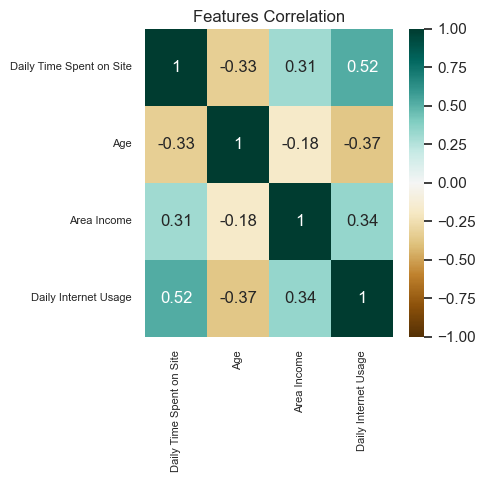

In [ ]:
plt.figure(figsize=(4, 4))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Features Correlation', fontsize=12, pad=5)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

**Summary:**
- The feature with the highest correlation is `Daily Time Spent on Site` with `Daily Internet Usage`, while the feature with the lowest correlation is `Age` with `Area Income`.

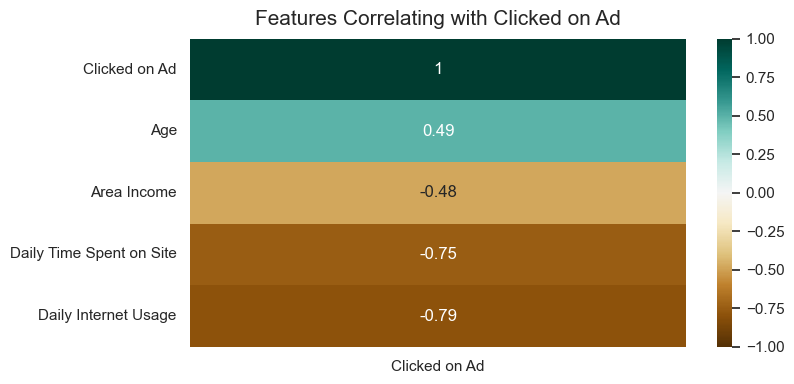

In [ ]:
df1 = df.copy()
df1['Clicked on Ad'] = df1['Clicked on Ad'].apply(lambda x: 1 if x == 'Yes' else 0)

plt.figure(figsize=(8,4))
heatmap = sns.heatmap(df1.corr()[['Clicked on Ad']].sort_values(by='Clicked on Ad', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Clicked on Ad', fontdict={'fontsize':15}, pad=10)
plt.show()

**Summary:**
- The feature with the highest correlation to the target is `Daily Internet Usage`, followed by `Daily Time Spent on Site`, `Age`, and the lowest is `Area Income`. The higher the correlation of a feature with the target, the more it influences the target <b>(clicked on the ad)</b>.

#### `Clicked on Ad` Analysis Based on `Age` and `Daily Time Spent on Site`

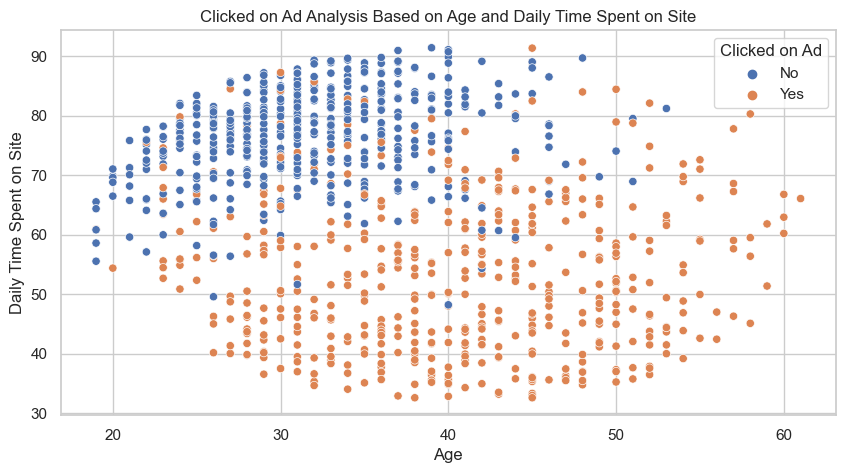

In [ ]:
plt.figure(figsize=(10,5))
plot = sns.scatterplot(data=df, x='Age', y='Daily Time Spent on Site', hue='Clicked on Ad')
plt.title('Clicked on Ad Analysis Based on Age and Daily Time Spent on Site')
plt.show()

**Insight:**
Younger customers with a higher daily time spent on the site tend to be less likely to click on ads. `However, it's important to note that not all younger customers refrain from clicking, as some of them still engage with the ads.` This suggests that the influence of age on clicking behavior is not as significant when compared to the influence of daily time spent on the site, where a larger portion of users who spend more time tend not to click on ads.

#### `Clicked on Ad` Analysis Based on `Age` and `Daily Internet Usage`

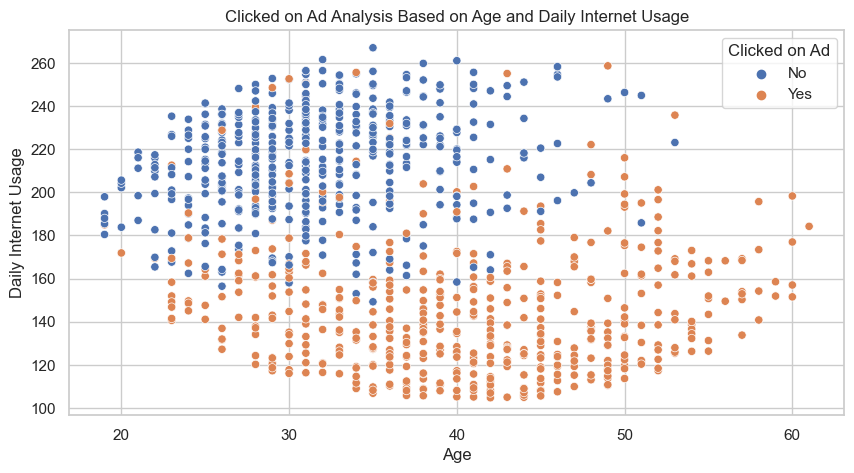

In [ ]:
plt.figure(figsize=(10,5))
plot = sns.scatterplot(data=df, x='Age', y='Daily Internet Usage', hue='Clicked on Ad')
plt.title('Clicked on Ad Analysis Based on Age and Daily Internet Usage')
plt.show()

**Insight:**
Younger customers with a higher daily internet usage tend to be less likely to click on ads. `However, it's important to note that not all younger customers refrain from clicking, as some of them still engage with the ads.` This suggests that the influence of age on clicking behavior is not as significant when compared to the influence of daily internet usage, where a larger portion of users who spend more time are less likely to click on ads.

#### `Clicked on Ad` Analysis Based on `Age` and `Area Income`

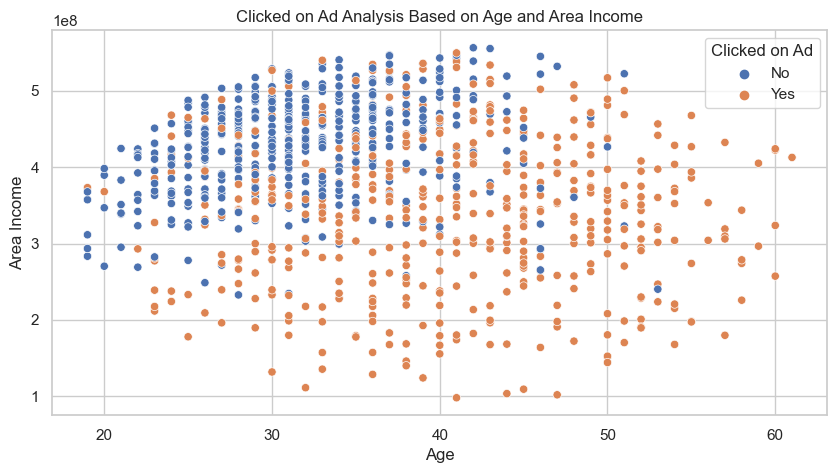

In [ ]:
plt.figure(figsize=(10,5))
plot = sns.scatterplot(data=df, x='Age', y='Area Income', hue='Clicked on Ad')
plt.title('Clicked on Ad Analysis Based on Age and Area Income')
plt.show()

**Insight:**
Younger customers with a higher area income tend to be less likely to click on ads. `However, it's important to note that there are still individuals within these categories who do engage with the ads.`

#### `Clicked on Ad` Analysis Based on `Daily Internet Usage` and `Daily Time Spent on Site`

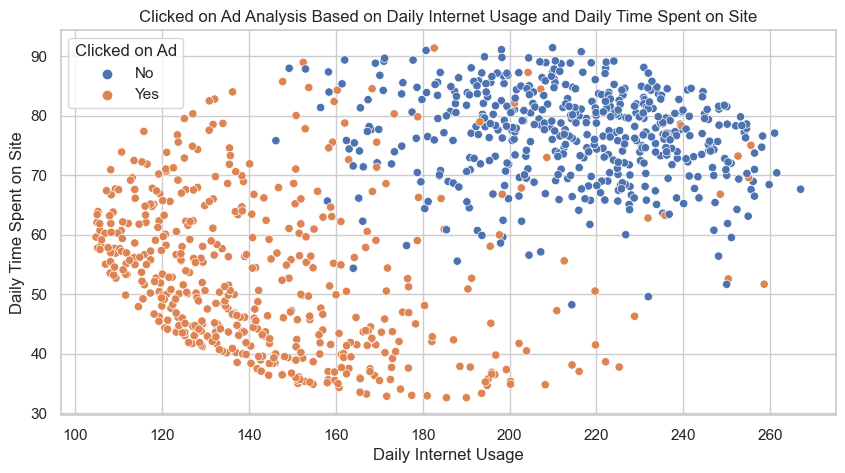

In [ ]:
plt.figure(figsize=(10,5))
plot = sns.scatterplot(data=df, x='Daily Internet Usage', y='Daily Time Spent on Site', hue='Clicked on Ad')
plt.title('Clicked on Ad Analysis Based on Daily Internet Usage and Daily Time Spent on Site')
plt.show()

**Insight:**
Customers with higher daily internet usage and daily time spent on site tend to be less likely to click on ads, and vice versa.

#### `Clicked on Ad` Analysis Based on `Daily Internet Usage` and `Area Income`

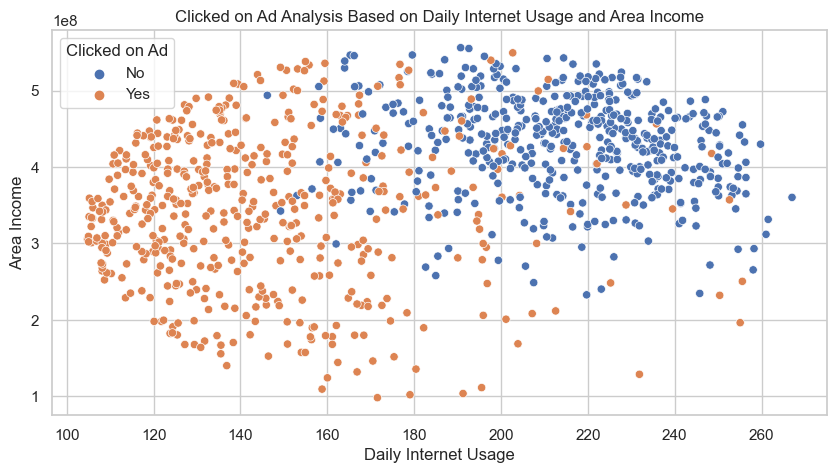

In [ ]:
plt.figure(figsize=(10,5))
plot = sns.scatterplot(data=df, x='Daily Internet Usage', y='Area Income', hue='Clicked on Ad')
plt.title('Clicked on Ad Analysis Based on Daily Internet Usage and Area Income')
plt.show()

**Insight:**
Customers with a higher daily internet usage and higher area income tend to be less likely to click on ads. `However, it's important to note that not all customers with higher area income refrain from clicking, as some of them still engage with the ads.` This suggests that the influence of area income on clicking behavior is not as significant when compared to the influence of daily internet usage, where a larger portion of users who spend more time are less likely to click on ads.

#### `Clicked on Ad` Analysis Based on `Daily Time Spent on Site` and `Area Income`

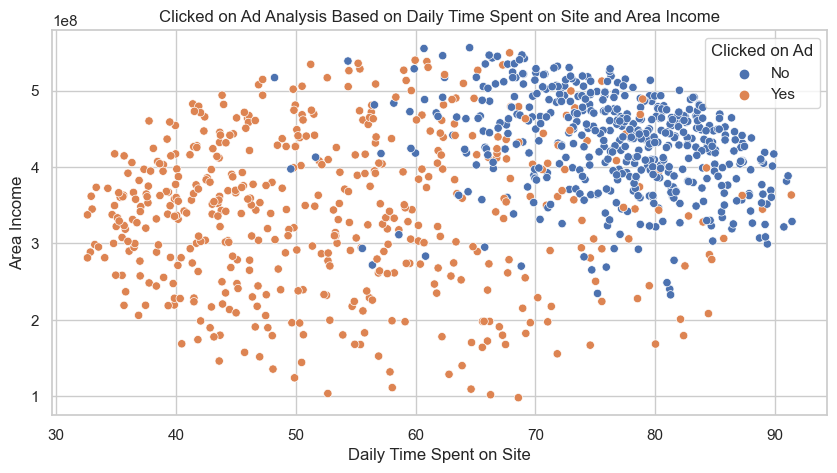

In [ ]:
plt.figure(figsize=(10,5))
plot = sns.scatterplot(data=df, x='Daily Time Spent on Site', y='Area Income', hue='Clicked on Ad')
plt.title('Clicked on Ad Analysis Based on Daily Time Spent on Site and Area Income')
plt.show()

**Insight:**
Customers with a higher daily time spent on site and higher area income tend to be less likely to click on ads. `However, it's important to note that not all customers with higher area income refrain from clicking, as some of them still engage with the ads.` This suggests that the influence of area income on clicking behavior is not as significant when compared to the influence of daily time spent on the site, where a larger portion of users who spend more time tend not to click on ads.

#### `Clicked on Ad` Analysis Based on `Timestamp`

In [ ]:
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M')

In [ ]:
# df['Month'] = df['Timestamp'].dt.month
# df['Day'] = df['Timestamp'].dt.day
# df['Hour'] = df['Timestamp'].dt.hour

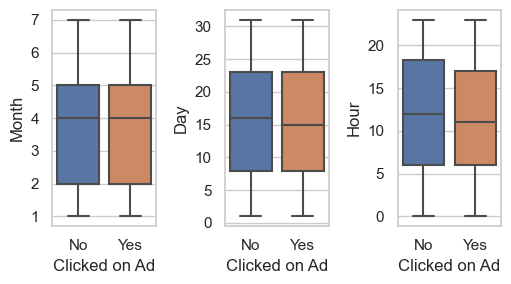

In [ ]:
# date_columns = ['Month', 'Day', 'Hour']
#
# plt.figure(figsize=(7, 3))
# for i in range(0, len(date_columns)):
#     plt.subplot(1, 4, i+1)
#     sns.boxplot(y = df[date_columns[i]], x = df['Clicked on Ad'], orient='v', showfliers = False)
#     plt.tight_layout()

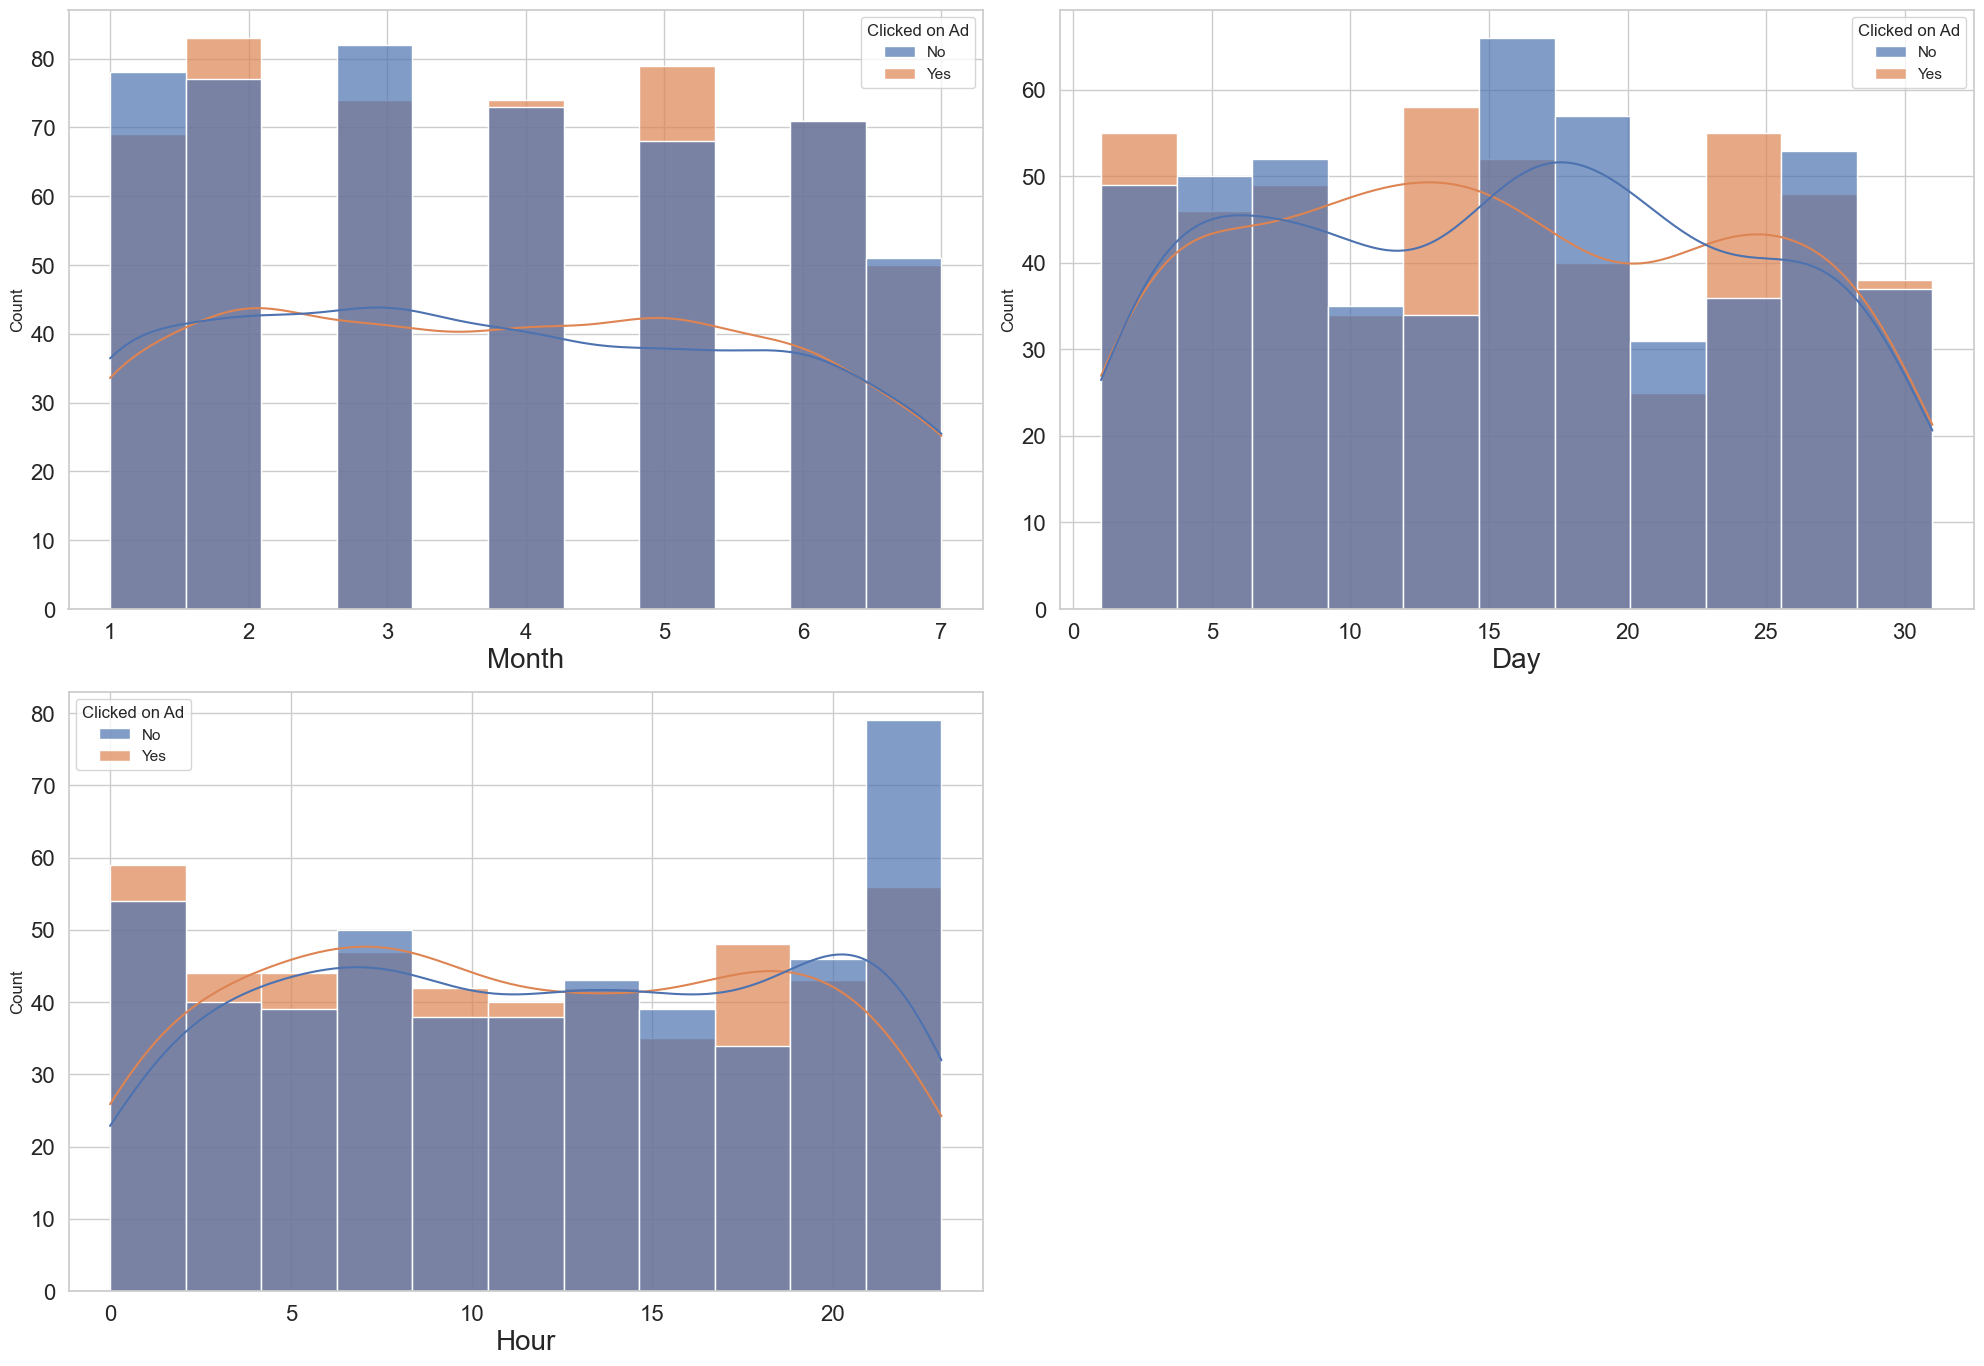

In [ ]:
# plt.figure(figsize=(20, 20))
# for i in range(0, len(date_columns)):
#     plt.subplot(len(date_columns)//1, 2, i+1)
#     ax = sns.histplot(x = df[date_columns[i]], kde = True, hue = df['Clicked on Ad'], alpha = 0.7)
#     ax.set_xlabel(str(date_columns[i]), fontsize = 20)
#     ax.tick_params(labelsize=16)
# plt.tight_layout()
# plt.show()

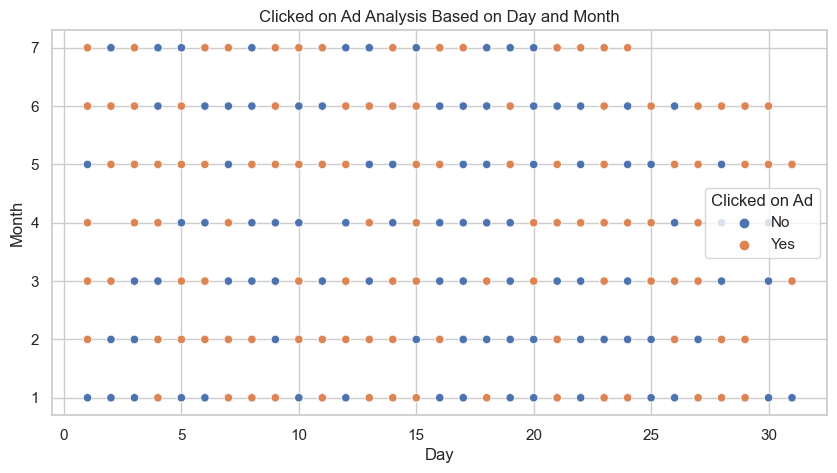

In [ ]:
# Visualize clicked on ad analysis based on day and month
# plt.figure(figsize=(10,5))
# plot = sns.scatterplot(data=df, x='Day', y='Month', hue='Clicked on Ad')
# plt.title('Clicked on Ad Analysis Based on Day and Month')
# plt.show()

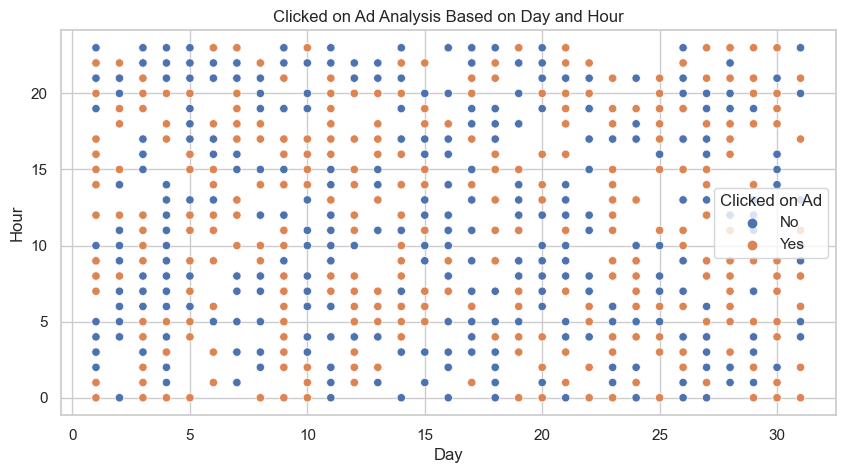

In [ ]:
# Visualize clicked on ad analysis based on day and hour
# plt.figure(figsize=(10,5))
# plot = sns.scatterplot(data=df, x='Day', y='Hour', hue='Clicked on Ad')
# plt.title('Clicked on Ad Analysis Based on Day and Hour')
# plt.show()

**Insight:**
Timestamps, whether on a daily, monthly, or hourly basis, are not directly correlated with the likelihood of clicking on an ad, as there is no specific timestamp threshold that explicitly indicates a higher click-through rate.

## Data Preprocessing

### Handling Missing Values

In [ ]:
# Check null values
df.isnull().sum()[df.isnull().sum() > 0]

Daily Time Spent on Site    13
Area Income                 13
Daily Internet Usage        11
Male                         3
dtype: int64

**Summary:**
- There are missing values in the following columns: `Daily Time Spent on Site` (13 data points), `Area Income` (13 data points), `Daily Internet Usage` (11 data points), and `Male` (3 data points).
    - Handling missing values in the `Daily Time Spent on Site` and `Daily Internet Usage` columns will be done through imputation based on the median value.
    - Handling missing values in the `Area Income` column will involve imputation based on the median value within a specific data subset.
    > - This will entail replacing missing values in the `Area Income` column with the median value from data that shares the same `city` value.
    - Handling missing values in the `Male` column will be done through imputation based on the mode value.

In [ ]:
# Impute using the median value
df['Daily Time Spent on Site'].fillna(df['Daily Time Spent on Site'].median(), inplace=True)
df['Daily Internet Usage'].fillna(df['Daily Internet Usage'].median(), inplace=True)

In [ ]:
# Impute using the median value from data that shares the same city value.
df['Area Income'].fillna(df.groupby('city')['Area Income'].transform('median'), inplace=True)

In [ ]:
# Impute using the mode value
df['Male'].fillna(df['Male'].mode()[0], inplace=True)

In [ ]:
# Check null values
null_counts = df.isnull().sum()
if null_counts[null_counts > 0].empty:
    print("There are no null values in the dataset.")
else:
    print("Columns with null values and their counts:")
    print(null_counts[null_counts > 0])

There are no null values in the dataset.


### Handling Duplicated Values

In [ ]:
print("Number of rows before removing duplicates:", len(df))
print("Number of rows after removing duplicates:", len(df.drop_duplicates()))

Number of rows before removing duplicates: 1000
Number of rows after removing duplicates: 1000


### Handling Invalid Values

In [ ]:
# Rename columns
df.rename(columns={'Male': 'Gender',
                  'city': 'City',
                  'province': 'Province',
                  'category': 'Category'}, inplace=True)

**Summary:**
- The column name `Male` is changed to `Gender` to better reflect its content, while the column `city`, `province`, and `category` are capitalized to maintain consistency with the naming of other columns.

In [ ]:
# Change the data type of the Timestamp column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [ ]:
# Replacing values in the Gender column
df['Gender'] = df['Gender'].replace({
    'Laki-Laki': 'Male',
    'Perempuan': 'Female'
})

# Replacing values in the City column
df['City'] = df['City'].replace({
    'Jakarta Timur': 'East Jakarta',
    'Jakarta Selatan': 'South Jakarta',
    'Jakarta Barat': 'West Jakarta',
    'Jakarta Utara': 'North Jakarta',
    'Jakarta Pusat': 'Central Jakarta',
    'Tangerang Selatan': 'South Tangerang'
})

# Replacing values in the Province column
df['Province'] = df['Province'].replace({
    'Daerah Khusus Ibukota Jakarta': 'Special Capital Region of Jakarta',
    'Jawa Barat': 'West Java',
    'Jawa Timur': 'East Java',
    'Jawa Tengah': 'Central Java',
    'Sumatra Utara': 'North Sumatra',
    'Sumatra Selatan': 'South Sumatra',
    'Kepulauan Riau': 'Riau Islands',
    'Kalimantan Timur': 'East Kalimantan',
    'Sulawesi Selatan': 'South Sulawesi',
    'Kalimantan Selatan': 'South Kalimantan',
    'Sumatra Barat': 'West Sumatra',
    'Kalimantan Barat': 'West Kalimantan'
})


# Replacing values in the Category column
df['Category'] = df['Category'].replace({
    'Otomotif': 'Automotive'
})

**Summary:**
- The change was made to align the language used in the column names and their data.

### Feature Extraction

In [ ]:
# df['Year'] = df['Timestamp'].dt.year --> Uniform values i.e 2016; making them less likely to be an important feature
df['Month'] = df['Timestamp'].dt.month
df['Week'] = df['Timestamp'].dt.strftime('%U').astype(int) + 1
df['Day'] = df['Timestamp'].dt.day

In [ ]:
# Drop unnecessary column
df.drop('Timestamp', axis=1, inplace=True) # Dropped to avoid redundancy with previously extracted features

### Handling Outliers

In [ ]:
# Handling outlier using IQR
#
# outliers1 = df.copy() # Makes a copy of the data to ensure that changes do not affect the dataframe to be used.
#
# print(f'The number of rows before filtering out the outliers: {len(outliers1)}')
#
# filtered_entries = np.array([True] * len(outliers1))
#
# Q1 = outliers1['Area Income'].quantile(0.25)
# Q3 = outliers1['Area Income'].quantile(0.75)
# IQR = Q3 - Q1
# low_limit = Q1 - (IQR * 1.5)
# high_limit = Q3 + (IQR * 1.5)
#
# filtered_entries = ((outliers1['Area Income'] >= low_limit) & (outliers1['Area Income'] <= high_limit)) & filtered_entries
#
# outliers1 = outliers1[filtered_entries]
#
# print(f'The number of rows after filtering out the outliers: {len(outliers1)}')

The number of rows before filtering out the outliers: 1000
The number of rows after filtering out the outliers: 991


In [ ]:
# Handling outlier using Z-Score
#
# from scipy import stats
#
# outliers2 = df.copy() # Makes a copy of the data to ensure that changes do not affect the dataframe to be used.
#
# print(f'The number of rows before filtering out the outliers: {len(outliers2)}')
#
# filtered_entries = np.array([True] * len(outliers2))
#
# zscore = abs(stats.zscore(outliers2['Area Income'])) # Calculate the absolute z-scores
# filtered_entries = (zscore < 3) & filtered_entries # Keep those with an absolute z-score less than 3
#
# outliers2 = outliers2[filtered_entries] # Filter and retain only those with a z-score below 3
#
# print(f'The number of rows after filtering out the outliers: {len(outliers2)}')

The number of rows before filtering out the outliers: 1000
The number of rows after filtering out the outliers: 997


In [ ]:
# Handling outliers using percentile 99
#
# outliers3 = df.copy()
#
# print("The number of rows before filtering out the outliers: ", outliers3.shape[0])
#
# percentile_99 = np.percentile(outliers3['Area Income'], 99)
# outliers3 = outliers3[outliers3['Area Income'] <= percentile_99]
#
# print("The number of rows before filtering out the outliers: ", outliers3.shape[0])

The number of rows before filtering out the outliers:  1000
The number of rows before filtering out the outliers:  990


**Summary:**
- Due to the very limited data size (1000 rows), outlier handling was not performed to prevent data loss. This decision was made because the values considered as outliers are not significantly distant from the other values.

### Feature Encoding

#### Label Encoding for `Clicked on Ad` column

In [ ]:
# Mapping for Clicked on Ad column
map_clicked = {
    'No': 0,
    'Yes': 1
}
df['Clicked on Ad'] = df['Clicked on Ad'].map(map_clicked)

#### One-Hot Encoding for `Gender`, `City`, `Province` and `Category` columns

In [ ]:
df = pd.get_dummies(df, columns=['Gender', 'City', 'Province', 'Category'])

In [ ]:
df_no_scaling = df.copy() # as a data without feature scaling

In [ ]:
df_scaling = df.copy() # dataset for feature scaling, then used as a data with feature scaling

### Feature Scaling

#### Log Transform for `Area Income` Column

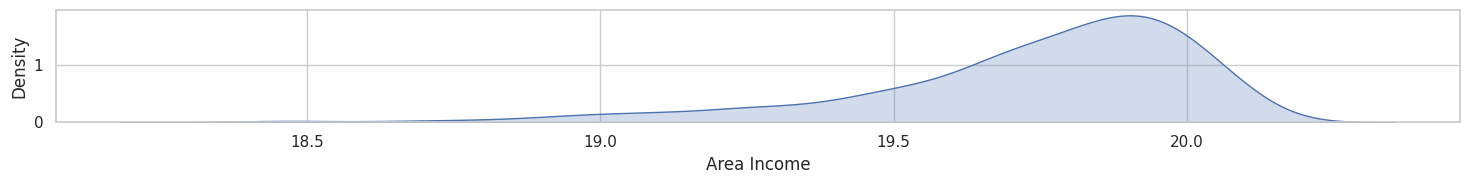

In [ ]:
df_scaling['Area Income'] = np.log(df_scaling['Area Income'])

plt.figure(figsize=(15, 2))
sns.kdeplot(df_scaling['Area Income'], shade=True)
plt.tight_layout()
plt.show()

#### Standardization for `Daily Time Spent on Site`, `Age`, `Daily Internet Usage`, `Month`, `Week`, `Day`, and `Area Income` Columns

In [ ]:
scalling_columns = ['Daily Time Spent on Site', 'Age', 'Daily Internet Usage', 'Month', 'Week', 'Day']

In [ ]:
scaler = StandardScaler()
df_scaling[scalling_columns] = scaler.fit_transform(df_scaling[scalling_columns])
df_scaling[scalling_columns].describe()

Daily Time Spent on Site     Age  Daily Internet Usage   Month    Week  \
count                   1000.00 1000.00               1000.00 1000.00 1000.00   
mean                      -0.00   -0.00                  0.00   -0.00   -0.00   
std                        1.00    1.00                  1.00    1.00    1.00   
min                       -2.06   -1.94                 -1.72   -1.46   -1.73   
25%                       -0.85   -0.80                 -0.94   -0.94   -0.90   
50%                        0.20   -0.11                  0.06    0.10   -0.07   
75%                        0.85    0.68                  0.88    0.61    0.88   
max                        1.68    2.85                  2.00    1.65    1.83   

          Day  
count 1000.00  
mean     0.00  
std      1.00  
min     -1.66  
25%     -0.86  
50%     -0.06  
75%      0.86  
max      1.78

### Separate Data for Feature and Target Columns

In [ ]:
# Data with feature scaling
X_scaling = df_scaling.drop('Clicked on Ad', axis=1)
y_scaling = df_scaling['Clicked on Ad']

In [ ]:
# Data without feature scaling
X_no_scaling = df_no_scaling.drop('Clicked on Ad', axis=1)
y_no_scaling = df_no_scaling['Clicked on Ad']

## Modeling

### Data Splitting

In [ ]:
# Splitting the data with feature scaling
train_scaling, test_scaling = train_test_split(df_scaling, test_size=0.2, stratify=df_scaling[['Clicked on Ad']], random_state=42)
train_scaling.reset_index(drop=True, inplace=True)
test_scaling.reset_index(drop=True, inplace=True)

print(train_scaling.shape)
print(test_scaling.shape)

(800, 66)
(200, 66)


In [ ]:
X_train_scaling = train_scaling.drop(['Clicked on Ad'], axis=1).reset_index(drop=True)
y_train_scaling = train_scaling['Clicked on Ad'].reset_index(drop=True)
print(X_train_scaling.shape, y_train_scaling.shape)

X_test_scaling = test_scaling.drop(['Clicked on Ad'], axis=1).reset_index(drop=True)
y_test_scaling = test_scaling['Clicked on Ad'].reset_index(drop=True)
print(X_test_scaling.shape, y_test_scaling.shape)

(800, 65) (800,)
(200, 65) (200,)


In [ ]:
# Splitting the data withot feature scaling
train_no_scaling, test_no_scaling = train_test_split(df_no_scaling, test_size=0.2, stratify=df_no_scaling[['Clicked on Ad']], random_state=42)
train_no_scaling.reset_index(drop=True, inplace=True)
test_no_scaling.reset_index(drop=True, inplace=True)

print(train_no_scaling.shape)
print(test_no_scaling.shape)

(800, 66)
(200, 66)


In [ ]:
X_train_no_scaling = train_no_scaling.drop(['Clicked on Ad'], axis=1).reset_index(drop=True)
y_train_no_scaling = train_no_scaling['Clicked on Ad'].reset_index(drop=True)
print(X_train_no_scaling.shape, y_train_no_scaling.shape)

X_test_no_scaling = test_no_scaling.drop(['Clicked on Ad'], axis=1).reset_index(drop=True)
y_test_no_scaling = test_no_scaling['Clicked on Ad'].reset_index(drop=True)
print(X_test_no_scaling.shape, y_test_no_scaling.shape)

(800, 65) (800,)
(200, 65) (200,)


#### Machine Learning Classification

In [ ]:
# Define estimators for each model
lr_model = LogisticRegression(solver='lbfgs', max_iter=len(X_train_scaling), random_state=42)
knn_model = KNeighborsClassifier()
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=2)
adaboost_model = AdaBoostClassifier(random_state=42)
xgboost_model = XGBClassifier(random_state=42)
nb_model = GaussianNB()
svc_model = SVC(kernel='rbf', probability=True, random_state=42)
nn_model = MLPClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

In [ ]:
train_classifier_list = []
train_modelname_list = []
train_metrics_list = []

test_classifier_list = []
test_modelname_list = []
test_metrics_list = []

In [ ]:
def evaluate_model_performance(model, model_name, X_train, y_train, X_test, y_test, should_save=True):
    # Predict on the training data
    train_predictions = model.predict(X_train)
    train_pred_prob = model.predict_proba(X_train)

    # Predict on the testing data
    test_predictions = model.predict(X_test)
    test_pred_prob = model.predict_proba(X_test)

    # Perform cross-validation for F1 and ROC AUC metrics on the data
    cv_f1_train = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1', n_jobs=-1)
    cv_rocauc_train = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)
    cv_f1_test = cross_val_score(model, X_test, y_test, cv=kf, scoring='f1', n_jobs=-1)
    cv_rocauc_test = cross_val_score(model, X_test, y_test, cv=kf, scoring='roc_auc', n_jobs=-1)

    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1 Score': f1_score,
        'ROC AUC': roc_auc_score
    }

    # Calculate various evaluation metrics on the training data
    train_metrics = {name: metric(y_train, train_predictions) for name, metric in metrics.items()}
    train_metrics['F1 Score (CV)'] = np.mean(cv_f1_train)
    train_metrics['ROC AUC (CV)'] = np.mean(cv_rocauc_train)

    # Calculate various evaluation metrics on the testing data
    test_metrics = {name: metric(y_test, test_predictions) for name, metric in metrics.items()}
    test_metrics['F1 Score (CV)'] = np.mean(cv_f1_test)
    test_metrics['ROC AUC (CV)'] = np.mean(cv_rocauc_test)

    if should_save:
        train_classifier_list.append(model)
        train_modelname_list.append(model_name)
        train_metrics_list.append(train_metrics)

        test_classifier_list.append(model)
        test_modelname_list.append(model_name)
        test_metrics_list.append(test_metrics)


    metrics_summary = pd.DataFrame({
        'Evaluation Metrics': list(metrics.keys()) + ['F1 Score (CV)', 'ROC AUC (CV)'],
        'Train': [train_metrics[name] for name in metrics.keys()] + [train_metrics['F1 Score (CV)'], train_metrics['ROC AUC (CV)']],
        'Test': [test_metrics[name] for name in metrics.keys()] + [test_metrics['F1 Score (CV)'], test_metrics['ROC AUC (CV)']]
    })

    metrics_summary["Diff Range"] = metrics_summary['Train'] - metrics_summary['Test']
    return metrics_summary.style.background_gradient(cmap='YlOrBr')

#### Logistic Regression Model

In [ ]:
# train the model using the data with feature scaling
lr_model = lr_model.fit(X_train_scaling, y_train_scaling)
evaluate_model_performance(lr_model, "Logistic Regression", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

In [ ]:
# train the model using the data without feature scaling

lr_model = LogisticRegression(solver='lbfgs', max_iter=len(X_train_no_scaling), random_state=42)
lr_model = lr_model.fit(X_train_no_scaling, y_train_no_scaling)
evaluate_model_performance(lr_model, "Logistic Regression", X_train_no_scaling, y_train_no_scaling, X_test_no_scaling, y_test_no_scaling)

#### k-Nearest Neighbors (kNN) Model

In [ ]:
# train the model using the data with feature scaling
knn_model = knn_model.fit(X_train_scaling, y_train_scaling)
evaluate_model_performance(knn_model, "K-Nearest Neighbors", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

In [ ]:
# train the model using the data without feature scaling
knn_model = knn_model.fit(X_train_no_scaling, y_train_no_scaling)
evaluate_model_performance(knn_model, "K-Nearest Neighbors", X_train_no_scaling, y_train_no_scaling, X_test_no_scaling, y_test_no_scaling)

#### Decision Tree Model

In [ ]:
# train the model using the data with feature scaling
dt_model = dt_model.fit(X_train_scaling, y_train_scaling)
evaluate_model_performance(dt_model, "Decision Tree", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

In [ ]:
# train the model using the data without feature scaling
dt_model = dt_model.fit(X_train_no_scaling, y_train_no_scaling)
evaluate_model_performance(dt_model, "Decision Tree", X_train_no_scaling, y_train_no_scaling, X_test_no_scaling, y_test_no_scaling)

#### Random Forest Model

In [ ]:
# train the model using the data with feature scaling
rf_model = rf_model.fit(X_train_scaling, y_train_scaling)
evaluate_model_performance(rf_model, "Random Forest", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

In [ ]:
# train the model using the data without feature scaling
rf_model = rf_model.fit(X_train_no_scaling, y_train_no_scaling)
evaluate_model_performance(rf_model, "Random Forest", X_train_no_scaling, y_train_no_scaling, X_test_no_scaling, y_test_no_scaling)

#### Adaboost Classifier Model

In [ ]:
# train the model using the data with feature scaling
adaboost_model = adaboost_model.fit(X_train_scaling, y_train_scaling)
evaluate_model_performance(adaboost_model, "Adaboost Classifier", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

In [ ]:
# train the model using the data without feature scaling
adaboost_model = adaboost_model.fit(X_train_no_scaling, y_train_no_scaling)
evaluate_model_performance(adaboost_model, "Adaboost Classifier", X_train_no_scaling, y_train_no_scaling, X_test_no_scaling, y_test_no_scaling)

#### XGBoost Classifier Model

In [ ]:
# train the model using the data with feature scaling
xgboost_model = xgboost_model.fit(X_train_scaling, y_train_scaling)
evaluate_model_performance(xgboost_model, "XGBoost Classifier", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

In [ ]:
# train the model using the data without feature scaling
xgboost_model = xgboost_model.fit(X_train_no_scaling, y_train_no_scaling)
evaluate_model_performance(xgboost_model, "XGBoost Classifier", X_train_no_scaling, y_train_no_scaling, X_test_no_scaling, y_test_no_scaling)

#### Gaussian Naive Bayes Model

In [ ]:
# train the model using the data with feature scaling
nb_model = nb_model.fit(X_train_scaling, y_train_scaling)
evaluate_model_performance(nb_model, "Naive Bayes", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

In [ ]:
# train the model using the data without feature scaling
nb_model = nb_model.fit(X_train_no_scaling, y_train_no_scaling)
evaluate_model_performance(nb_model, "Naive Bayes", X_train_no_scaling, y_train_no_scaling, X_test_no_scaling, y_test_no_scaling)

#### Support Vector Machine Model

In [ ]:
# train the model using the data with feature scaling
svm_model = svc_model.fit(X_train_scaling, y_train_scaling)
evaluate_model_performance(svm_model, "Support Vector Machine", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

In [ ]:
# train the model using the data without feature scaling
svm_model = svc_model.fit(X_train_no_scaling, y_train_no_scaling)
evaluate_model_performance(svm_model, "Support Vector Machine", X_train_no_scaling, y_train_no_scaling, X_test_no_scaling, y_test_no_scaling)

#### Neural Network Classifier

In [ ]:
# train the model using the data with feature scaling
nn_model = nn_model.fit(X_train_scaling, y_train_scaling)
evaluate_model_performance(nn_model, "Neural Network Classifier", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

In [ ]:
# train the model using the data without feature scaling
nn_model = nn_model.fit(X_train_no_scaling, y_train_no_scaling)
evaluate_model_performance(nn_model, "Neural Network Classifier", X_train_no_scaling, y_train_no_scaling, X_test_no_scaling, y_test_no_scaling)

#### Gradient Boosting Classifier

In [ ]:
# train the model using the data with feature scaling
gb_model = gb_model.fit(X_train_scaling, y_train_scaling)
evaluate_model_performance(gb_model, "GradientBoosting Classifier", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

In [ ]:
# train the model using the data without feature scaling
gb_model = gb_model.fit(X_train_no_scaling, y_train_no_scaling)
evaluate_model_performance(gb_model, "GradientBoosting Classifier", X_train_no_scaling, y_train_no_scaling, X_test_no_scaling, y_test_no_scaling)

#### Each Model's Performance

In [ ]:
results_eval = pd.DataFrame({
    "Models": test_modelname_list,
    "Accuracy (Train)": [metrics['Accuracy'] for metrics in train_metrics_list],
    "Accuracy (Test)": [metrics['Accuracy'] for metrics in test_metrics_list],
    "Precision (Train)": [metrics['Precision'] for metrics in train_metrics_list],
    "Precision (Test)": [metrics['Precision'] for metrics in test_metrics_list],
    "Recall (Train)": [metrics['Recall'] for metrics in train_metrics_list],
    "Recall (Test)": [metrics['Recall'] for metrics in test_metrics_list],
    "F1 Score (Train)": [metrics['F1 Score'] for metrics in train_metrics_list],
    "F1 Score (Test)": [metrics['F1 Score'] for metrics in test_metrics_list]
})

results_eval.drop_duplicates(inplace=True)

results_eval.sort_values(by=["Recall (Test)", "Accuracy (Test)", "F1 Score (Test)", "Precision (Test)"], ascending=[False, False, False, False]).reset_index(drop=True)
results_eval_styled = results_eval.style.background_gradient(cmap='YlOrBr')
results_eval_styled

**Summary:**
- The first row represents models with feature scaling, while the second row represents models without scaling.
- `Decision Tree`, `Random Forest`, `AdaBoost Classifier`, `XGBoost Classifier`, and `Gradient Boosting Classifier` models show consistent performance whether data is scaled or not. However, for other models, performance is better with feature scaling.
  > Some models, such as `Decision Tree`, `Random Forest`, `AdaBoost, XGBoost`, and `Gradient Boosting`, are less influenced by feature scaling as they build models by separating data based on specific features. Consequently, the performance between data with feature scaling and without feature scaling remains similar for these models.In contrast, models like `Logistic Regression`, `K-Nearest Neighbors (KNN)`, and `Neural Networks` are more sensitive to feature scaling. Therefore, data with feature scaling aids in improving the performance of these models.
- The top-performing models are <b>AdaBoost Classifier; Logistic Regression, K-Nearest Neighbors,</b> and <b>Neural Network Classifier (with data scaling)</b> exhibiting the most consistent and stable performance across all recall, accuracy, and precision metrics.

### Hyperparameter Tuning

#### Logistic Regression Model

In [ ]:
from sklearn.metrics import make_scorer

# List of hyperparameter values
C = [0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [100, 200, 300, 400, 500]
hyperparameters = {
    'C': C,
    'penalty': penalty,
    'solver': solver,
    'max_iter': max_iter
}

logreg = LogisticRegression()
cv = StratifiedKFold(n_splits=5)
custom_scoring = make_scorer(recall_score)
logreg_model_ht = RandomizedSearchCV(
    logreg, hyperparameters, cv=cv, scoring=custom_scoring, refit="f1", random_state=1
)

grid_result = logreg_model_ht.fit(X_train_scaling, y_train_scaling)
print("Best Recall Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Recall Score: 0.937500 using {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 10}


In [ ]:
logreg_model_ht = LogisticRegression(solver = 'lbfgs', penalty = 'l2', max_iter = 300, C = 10)
logreg_model_ht.fit(X_train_scaling,y_train_scaling)

LogisticRegression(C=10, max_iter=300)

In [ ]:
evaluate_model_performance(logreg_model_ht, "Logistic Regression", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

#### k-Nearest Neighbor (kNN) Model

In [ ]:
# from sklearn.model_selection import StratifiedKFold
#
# List of hyperparameter values
# n_neighbors = list(range(1, 21))  # Adjust the range as needed
# weights = ['uniform', 'distance']
# metric = ['euclidean', 'manhattan', 'chebyshev']
#
# hyperparameters = {
#     'n_neighbors': n_neighbors,
#     'weights': weights,
#     'metric': metric
# }
#
# knn = KNeighborsClassifier()
# cv = StratifiedKFold(n_splits=5)
# custom_scoring = make_scorer(recall_score)
# knn_model_ht = RandomizedSearchCV(knn, hyperparameters, cv=cv, scoring=custom_scoring, refit="f1", random_state=1)
#
# grid_result = knn_model_ht.fit(X_train_scaling, y_train_scaling)
# print("Best Recall Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Recall Score: 0.915000 using {'weights': 'distance', 'n_neighbors': 19, 'metric': 'chebyshev'}


In [ ]:
# knn_model_ht = KNeighborsClassifier(weights = 'uniform', n_neighbors = 10, metric = 'chebyshev')
# knn_model_ht.fit(X_train_scaling, y_train_scaling)

KNeighborsClassifier(metric='chebyshev', n_neighbors=10)

In [ ]:
# evaluate_model_performance(knn_model_ht, "K-Nearest Neighbors", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

#### Adaboost Classifier

In [ ]:
# from scipy.stats import uniform, randint
#
# Define the hyperparameter search space
# hyperparameters = {
#     'n_estimators': randint(50, 200),  # Number of weak learners
#     'learning_rate': uniform(0.01, 1),  # Learning rate
#     'algorithm': ['SAMME', 'SAMME.R']  # Boosting algorithm
# }
#
# adaboost = AdaBoostClassifier()
# cv = StratifiedKFold(n_splits=5)
# scorer = make_scorer(recall_score)
# adaboost_model_ht = RandomizedSearchCV(adaboost, hyperparameters, cv=cv, scoring=scorer, refit=True, random_state=1)
#
# adaboost_model_ht.fit(X_train_scaling, y_train_scaling)
# print("Best Recall Score:", adaboost_model_ht.best_score_)
# print("Best Hyperparameters:", adaboost_model_ht.best_params_)

Best Recall Score: 0.9550000000000001
Best Hyperparameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0071848109388686, 'n_estimators': 122}


In [ ]:
# best_adaboost = adaboost_model_ht.best_estimator_
# best_adaboost.fit(X_train_scaling, y_train_scaling)

AdaBoostClassifier(learning_rate=1.0071848109388686, n_estimators=122)

In [ ]:
# evaluate_model_performance(best_adaboost, "Adaboost Classifier", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

#### Neural Network Classifier

In [ ]:
# hyperparameters = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
#     'activation': ['logistic', 'tanh', 'relu'],
#     'alpha': uniform(1e-5, 1e-2),
#     'learning_rate_init': uniform(0.001, 0.1),
# }
#
# mlp = MLPClassifier()
# cv = StratifiedKFold(n_splits=5)
# scorer = make_scorer(recall_score)
# mlp_model_ht = RandomizedSearchCV(mlp, hyperparameters, cv=cv, scoring=scorer, refit=True, random_state=1)
#
# mlp_model_ht.fit(X_train_scaling, y_train_scaling)
# print("Best Recall Score:", mlp_model_ht.best_score_)
# print("Best Hyperparameters:", mlp_model_ht.best_params_)

Best Recall Score: 0.9299999999999999
Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.0014775589081711304, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.04065807272960262}


In [ ]:
# best_nn = mlp_model_ht.best_estimator_
# best_nn.fit(X_train_scaling, y_train_scaling)

MLPClassifier(activation='tanh', alpha=0.0014775589081711304,
              hidden_layer_sizes=(50,), learning_rate_init=0.04065807272960262)

In [ ]:
# evaluate_model_performance(best_nn, "Neural Network Classifier", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

### Model Selection

After hyperparameter tuning for the top 4 performing models, the most stable model is the <b>AdaBoost Classifier</b> without hyperparameter tuning.

In [ ]:
adaboost_model = adaboost_model.fit(X_train_scaling, y_train_scaling)
evaluate_model_performance(adaboost_model, "Adaboost Classifier", X_train_scaling, y_train_scaling, X_test_scaling, y_test_scaling)

### Model Evaluation

In [ ]:
def evaluate_model(X, y, model, model_name, y_pred, y_pred_prob, title):
    accuracy = round(accuracy_score(y, y_pred), 2)
    precision = round(precision_score(y, y_pred), 2)
    recall = round(recall_score(y, y_pred), 2)
    f1_s = round(f1_score(y, y_pred), 2)
    rocauc_score = round(roc_auc_score(y, y_pred_prob[:, 1]), 2)

    cv_score_f1 = cross_validate(model, X, y, cv=kf, scoring='f1', return_train_score=True)
    csf_score = round(cv_score_f1['train_score'].mean(), 2)

    cv_score_rocauc = cross_validate(model, X, y, cv=kf, scoring='roc_auc', return_train_score=True)
    csr_score = round(cv_score_rocauc['train_score'].mean(), 2)

    print(f'Accuracy = {accuracy}')
    print(f'Precision = {precision}')
    print(f'Recall = {recall}')
    print(f'F1 Score = {f1_s}')
    print(f'Cross Val F1 (k=5) = {csf_score}')
    print(f'ROC AUC = {rocauc_score}')
    print(f'Cross Val ROC AUC (k=5) = {csr_score}\n')

    print(classification_report(y, y_pred))

    conf_matrix = pd.DataFrame((confusion_matrix(y, y_pred)), ('No Clicked', 'Clicked'), ('No Clicked', 'Clicked'))
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    print("Actual Data")
    print("Total =", len(y))
    print("No Clicked =", len(y[y == 0]))
    print("Clicked =", len(y[y == 1]))
    print("Predicted Data")
    print("TP = {}, FP = {}, TN = {}, FN = {}".format(tp, fp, tn, fn))
    print("Predictly Correct =", tn+tp)
    print("Predictly Wrong =", fn+fp, "\n")

    plt.figure(figsize=[8,5])

    c_matrix = confusion_matrix(y, y_pred)
    names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = ['{0:0.0f}'.format(value) for value in c_matrix.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    heatmap = sns.heatmap(conf_matrix, annot = labels, annot_kws={'size': 13}, fmt='', cmap='YlOrBr')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=13)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=13)

    plt.title(f'Confusion Matrix for {title}\n', fontsize=13, color='black')
    plt.ylabel('Actual Label', fontsize=13)
    plt.xlabel('\nPredicted Label', fontsize=13)
    plt.show()
    print("\n")

    plt.figure(figsize=[8,5])
    fpr, tpr, threshold = roc_curve(y, y_pred_prob[:, 1])
    plt.plot(fpr, tpr, label = model_name+' (Area (Score) = %0.2f)'%rocauc_score)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

Accuracy = 0.98
Precision = 0.99
Recall = 0.98
F1 Score = 0.98
Cross Val F1 (k=5) = 0.99
ROC AUC = 1.0
Cross Val ROC AUC (k=5) = 1.0

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       500
           1       0.99      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.98      0.98      1000

Actual Data
Total = 1000
No Clicked = 500
Clicked = 500
Predicted Data
TP = 491, FP = 6, TN = 494, FN = 9
Predictly Correct = 985
Predictly Wrong = 15 



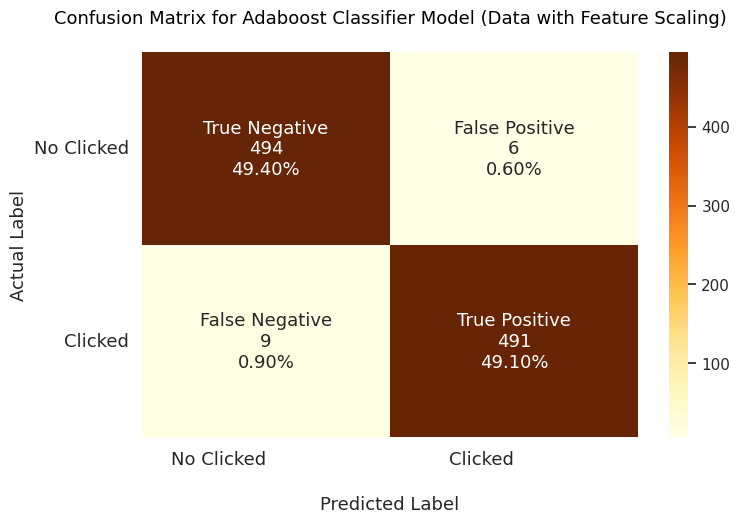

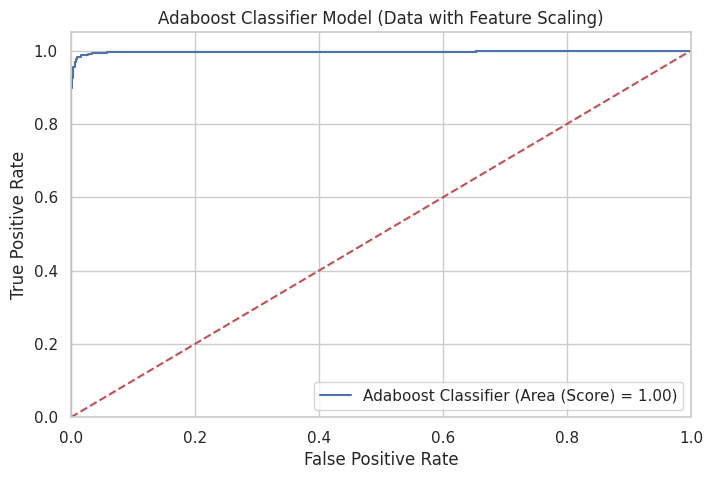

In [ ]:
# Generate predictions
y_pred = adaboost_model.predict(X_scaling)
y_pred_prob = adaboost_model.predict_proba(X_scaling)

# Call the evaluation function for training
evaluate_model(X_scaling, y_scaling, adaboost_model, 'Adaboost Classifier', y_pred, y_pred_prob, 'Adaboost Classifier Model (Data with Feature Scaling)')

Accuracy = 0.98
Precision = 0.99
Recall = 0.98
F1 Score = 0.98
Cross Val F1 (k=5) = 0.99
ROC AUC = 1.0
Cross Val ROC AUC (k=5) = 1.0

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       500
           1       0.99      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.98      0.98      1000

Actual Data
Total = 1000
No Clicked = 500
Clicked = 500
Predicted Data
TP = 491, FP = 6, TN = 494, FN = 9
Predictly Correct = 985
Predictly Wrong = 15 



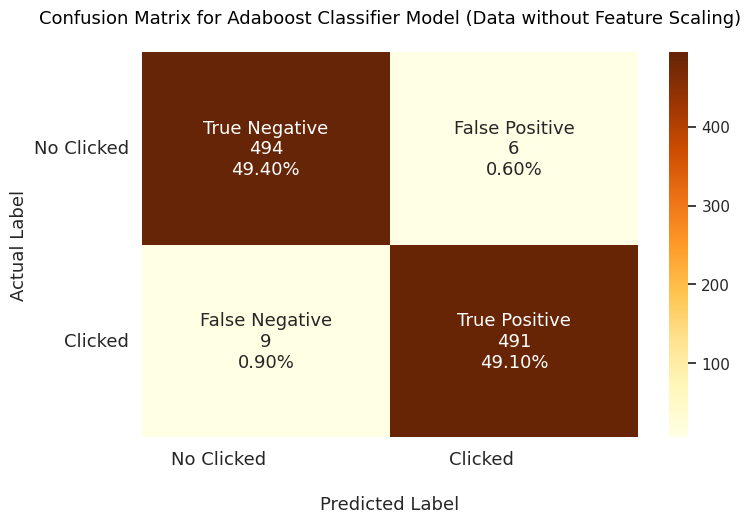

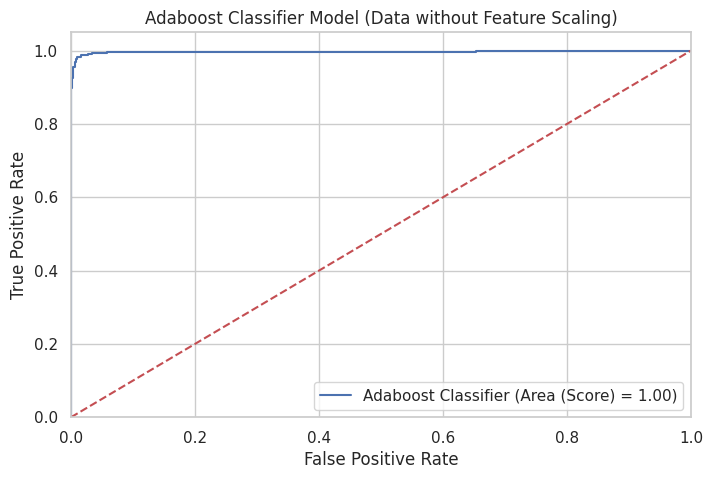

In [ ]:
# Generate predictions
y_pred = adaboost_model.predict(X_no_scaling)
y_pred_prob = adaboost_model.predict_proba(X_no_scaling)

# Call the evaluation function for training
evaluate_model(X_no_scaling, y_no_scaling, adaboost_model, 'Adaboost Classifier', y_pred, y_pred_prob, 'Adaboost Classifier Model (Data without Feature Scaling)')

**Summary:**
The performance of the model and the confusion matrix values are the same for data with and without feature scaling. This could be due to the narrow data range and the relatively small dataset size. To minimize the risk of errors when dealing with more complex data or significant scale variations in the future, <b>the choice is to opt for the model with feature scaling</b>. This decision is supported by the condition where outliers were not handled previously due to the limited data, and the application of feature scaling is expected to address this issue for similar cases in the future.

### Feature Importance

In [ ]:
def shap_plot(model, model_name, data=None):

    model_name = re.sub('\s*\(\w*\)\s*', '', model_name)

    tree = ["Decision Tree", "Random Forest", "XGBoost Classifier", "Gradient Boosting Classifier"]

    shap.initjs()

    if model_name in tree:

        if model_name in ["XGBoost Classifier", "Gradient Boosting Classifier"] :
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(data)
            expected = explainer.expected_value
        else:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(data)[1]
            expected = explainer.expected_value[1]


        fig = plt.figure()
        ax0 = fig.add_subplot(121)
        shap.summary_plot(shap_values, data, show = False)
        ax1 = fig.add_subplot(122)
        shap.summary_plot(shap_values, data, plot_type='bar', show = False, cmap = "plasma")
        plt.gcf().set_size_inches(20,8)
        plt.tight_layout()
        plt.show()

        return shap.force_plot(expected, shap_values[0], data.iloc[0,:], plot_cmap = "PkYg", show = False)

    else :
        explainer = shap.Explainer(model.predict, data)
        shap_values = explainer(data)

        fig = plt.figure()
        ax0 = fig.add_subplot(121)
        shap.summary_plot(shap_values.values, data, show = False)
        ax1 = fig.add_subplot(122)
        shap.summary_plot(shap_values.values, data, plot_type='bar', show = False, cmap = "plasma")
        plt.gcf().set_size_inches(20,8)
        plt.tight_layout()
        plt.show()

        return shap.force_plot(shap_values.base_values[0], shap_values.values[0], data.iloc[0,:], plot_cmap = "PkYg", show = False)

PermutationExplainer explainer: 1001it [02:11,  7.01it/s]


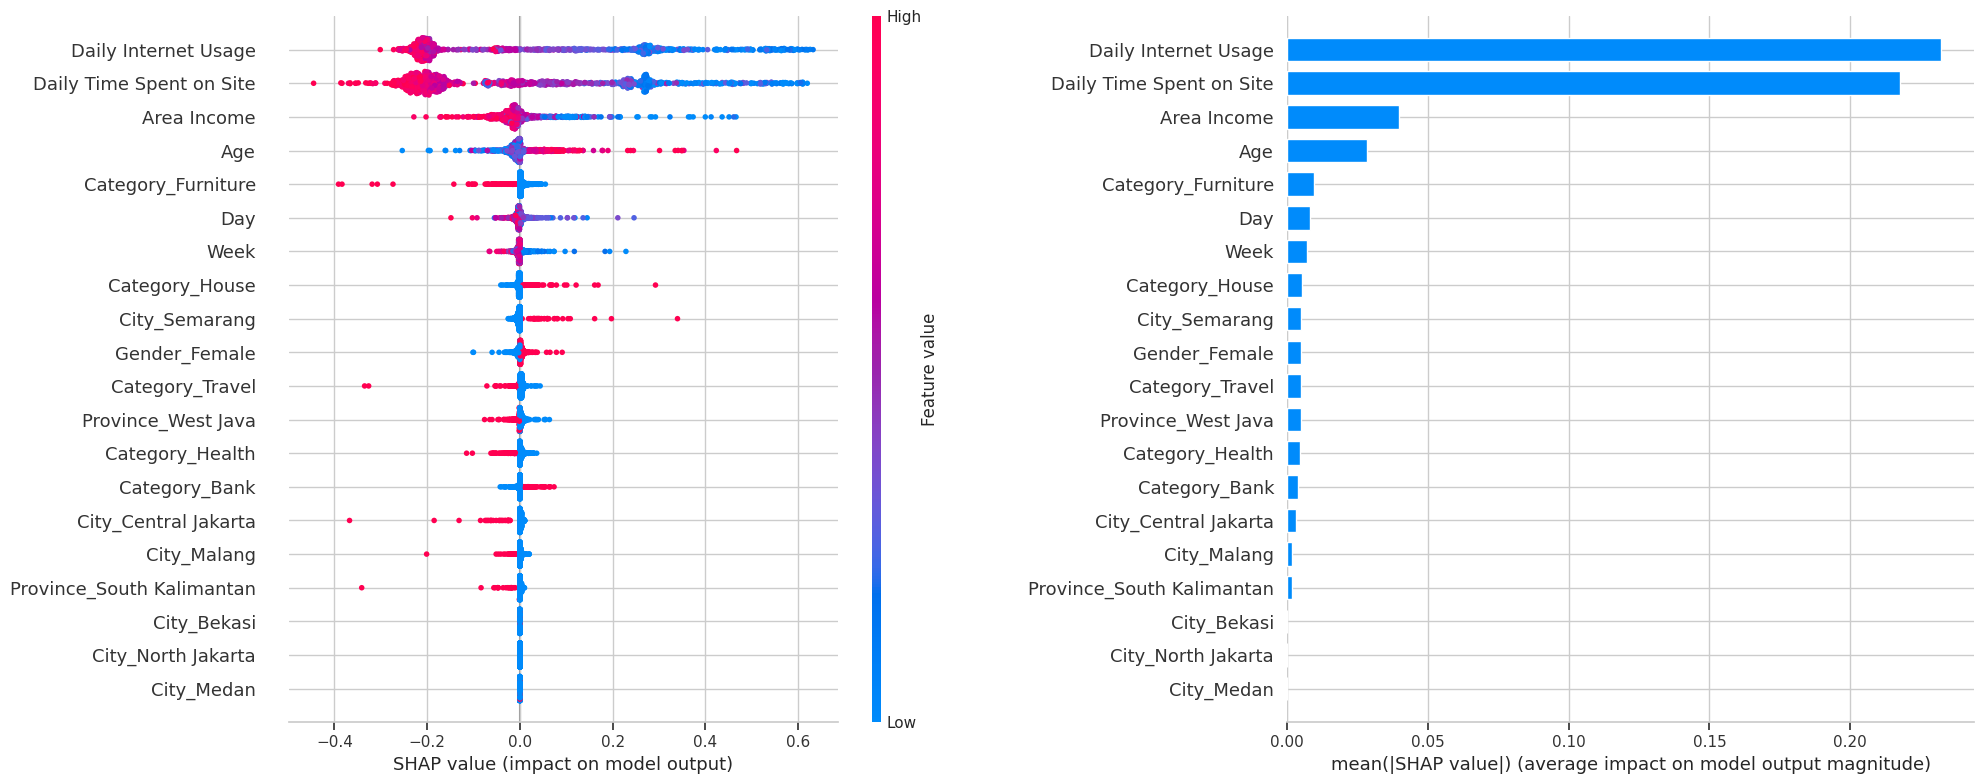

In [ ]:
shap_plot(adaboost_model, "Adaboost Classifier", X_scaling)

**Summary:**
The two most important features obtained from the model are daily internet usage and daily time spent on the site. Their feature values lean to the left, indicating that the lower the time spent by a customer, the higher the likelihood of that customer clicking on the advertisement.

## Business Insight and Recommendation

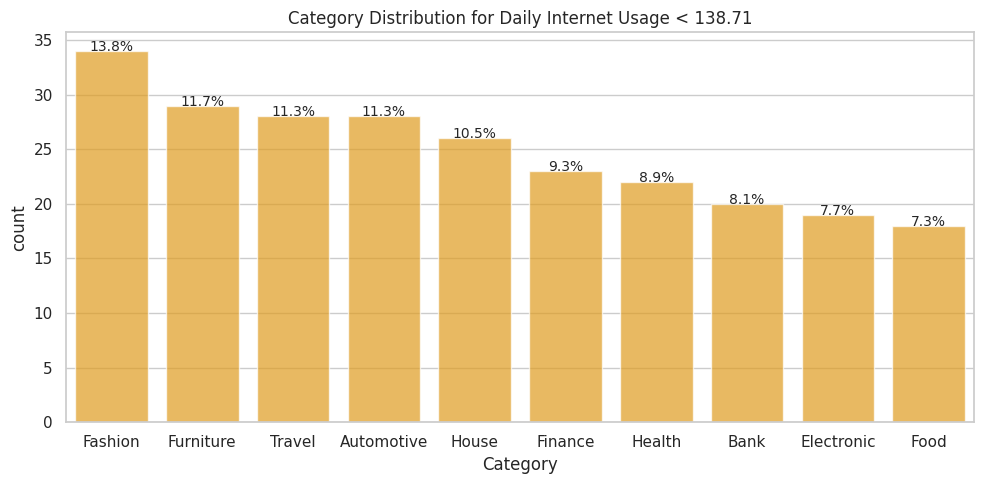

In [ ]:
filtered_df = df[(df['Clicked on Ad'] == 'Yes') & (df['Daily Internet Usage'] < 138.71)]
order = filtered_df['Category'].value_counts().index

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=filtered_df['Category'], order=order, color='orange', alpha=0.7)

total = len(filtered_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height()
    ax.annotate(percentage, (x, y), fontsize=10, ha='center')

plt.title('Category Distribution for Daily Internet Usage < 138.71')
plt.tight_layout()
plt.show()

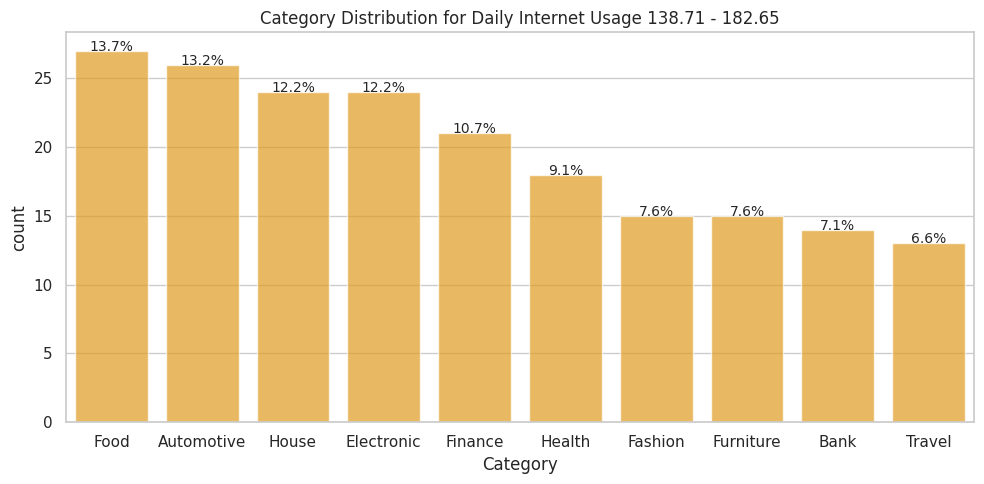

In [ ]:
filtered_df = df[(df['Clicked on Ad'] == 'Yes') & (df['Daily Internet Usage'] >= 138.71) & (df['Daily Internet Usage'] < 182.65)]
order = filtered_df['Category'].value_counts().index

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=filtered_df['Category'], order=order, color='orange', alpha=0.7)

total = len(filtered_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height()
    ax.annotate(percentage, (x, y), fontsize=10, ha='center')

plt.title('Category Distribution for Daily Internet Usage 138.71 - 182.65')
plt.tight_layout()
plt.show()

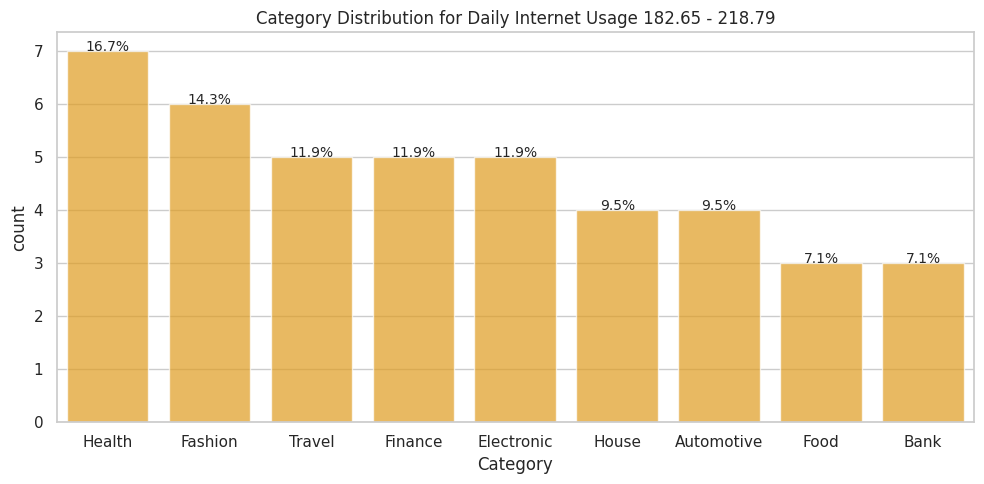

In [ ]:
filtered_df = df[(df['Clicked on Ad'] == 'Yes') & (df['Daily Internet Usage'] >= 182.65) & (df['Daily Internet Usage'] < 218.79) ]
order = filtered_df['Category'].value_counts().index

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=filtered_df['Category'], order=order, color='orange', alpha=0.7)

total = len(filtered_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height()
    ax.annotate(percentage, (x, y), fontsize=10, ha='center')

plt.title('Category Distribution for Daily Internet Usage 182.65 - 218.79')
plt.tight_layout()
plt.show()

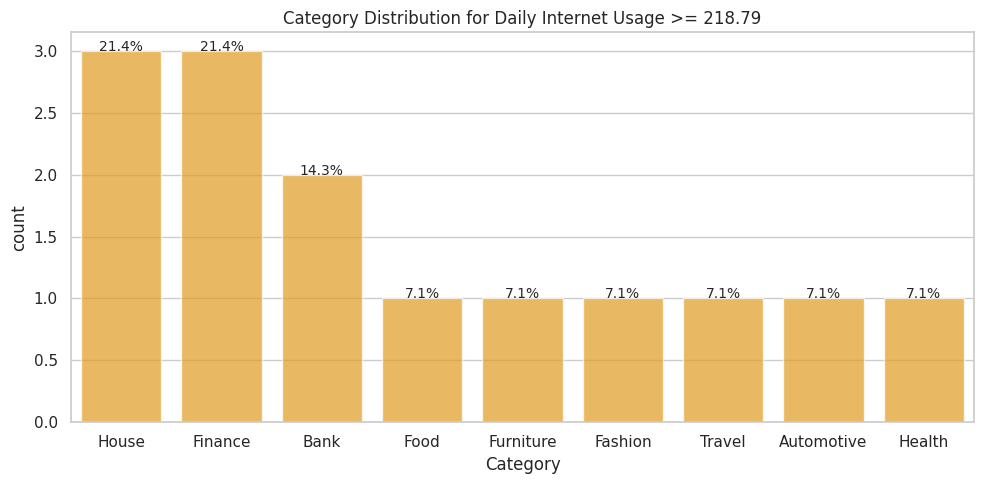

In [ ]:
filtered_df = df[(df['Clicked on Ad'] == 'Yes') & (df['Daily Internet Usage'] >= 218.79) ]
order = filtered_df['Category'].value_counts().index

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=filtered_df['Category'], order=order, color='orange', alpha=0.7)

total = len(filtered_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height()
    ax.annotate(percentage, (x, y), fontsize=10, ha='center')

plt.title('Category Distribution for Daily Internet Usage >= 218.79')
plt.tight_layout()
plt.show()

**Insight:**
From several observed time segments, there is no apparent preference for ad categories, as all ad categories are clicked at proportions that do not significantly differ from one another.

**Business Recommendation:**
1. Simplified and Compact Ad Messages:
  > For example, place the core ad message at the top of the image to enhance attractiveness and message clarity.
2. Image and Source Code Optimization:
  > Based on customer behavior, ad clicks are more likely when daily internet usage and website loading times are lower. Optimize images and source code to speed up loading and maximize ad effectiveness.
3. Time-Centric Ad Messaging:
  > Incorporate time-sensitive messages in ads, such as 'visit now' or 'valid for the next 30 minutes.' This creates a sense of urgency and encourages customer action. The 30-minute timeframe is selected based on the lowest daily customer spending time (±32 minutes).
4. Cookie System Implementation, e.g., Persistent Cookies:
  > Considering varying customer ad preferences where all categories receive clicks in proportions that do not significantly differ, implement a cookie system to track user preferences and behavior while still adhering to privacy regulations and providing options for customers to consent or reject these cookies.